In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from make_map import make_map

from file_util import load_matlab_data
from plot import plot_discharge
from metrics import *
from stratigraphy import sedimentograph
from spatial_dist import *
from glob import glob


from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString
import rasterio
from rasterio.features import shapes

from osgeo import ogr, gdal, osr
from shapely.ops import transform, polygonize_full
from scipy.ndimage import morphology

import cPickle as pickle
import fiona
import itertools
import clusterpy
from scipy.cluster.vq import kmeans,vq
from numpy.random import rand
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import networkx as nx
import matplotlib as mpl

from metrics_scripts.metrics_utils import *
from metrics_scripts.island_creation_utils import *
from metrics_scripts.island_metric_utils import *
from metrics_scripts.channel_metric_utils import *

In [2]:
filename = 'ganges_metrics/gangeschan.tif'

ganges_mask, params = read_tiff_as_array(filename, get_info = True, normalize = True)
r_xmax, r_xmin, r_ymax, r_ymin, r_xres, r_yres = params

pixel_size = r_xres

downsample = 1

if downsample > 1:
    ganges_mask = ganges_mask[::downsample,::downsample]
    pixel_size = r_xres * downsample

mapfile = {}
mapfile['landmap'] = ganges_mask
mapfile['islandmap'] = ganges_mask

In [3]:
# get islands from network shapefile
filename = 'ganges_metrics/network.shp'
parameters = ['Width']

network_lines, network_params = load_shapefile(filename, parameters)

islands = polygonize_shapely_lines(network_lines, size_threshold = pixel_size * pixel_size * 10)

In [4]:
islands, contained_islands = find_nested_islands(islands, merge_islands = True)

In [5]:
bounds, interior_channels = find_bounding_channels(network_lines,
                                                   islands,
                                                   load_saved = True,
                                                   file_root = 'ganges_metrics')

flat_bounds = np.unique([item for sublist in bounds for item in sublist])

In [7]:
create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/islands_area_polygons.shp')

In [6]:
# create shapefile and raster of the network islands

create_island_GIS = False

if create_island_GIS:

    channel_bounds = MultiLineString([network_lines[i] for i in flat_bounds])

    create_shapefile_from_shapely_multi(channel_bounds,
                                        'ganges_metrics/islands_polygons.shp',
                                        buffer_width = 150)


    create_tiff_from_shapefile(source = 'ganges_metrics/islands_polygons.shp',
                               target = 'ganges_metrics/islands_polygons.tif',
                               reference_image = 'ganges_metrics/gangeschan.tif')

In [6]:
network_raster = read_tiff_as_array('ganges_metrics/islands_polygons.tif', get_info = False)

mapfile['islandmap'] = mapfile['islandmap'] & (network_raster == 0)
island_label_map, = island_properties(mapfile, smooth = False, properties = False)

island_labels, poly_index, bad_pts = get_value_of_raster_within_polygons(island_label_map,
                                                                      islands,
                                                                      r_xmin, r_xmax,
                                                                      r_ymin, r_ymax,
                                                                      min_valid_label = 3)

In [8]:
rasterOrigin = (r_xmin, r_ymin)
pixelWidth = r_xres * 5
pixelHeight = r_xres * 5
newRasterfn = 'ganges_metrics/island_map_HD.tif'
array = island_label_map

reversed_arr = array[::-1] # reverse array so the tif looks like the array
array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

In [13]:
rasterOrigin = (r_xmin, r_ymin)
pixelWidth = r_xres * 5
pixelHeight = r_xres * 5
newRasterfn = 'ganges_metrics/island_map_HD_mask.tif'
array = island_label_map < 3

reversed_arr = array[::-1] # reverse array so the tif looks like the array
array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

In [10]:
polygons = islands
raster = island_label_map

poly_points_utm = [i.representative_point().coords[0] for i in polygons]

poly_points_index = ([latlong_to_index(i,
                      r_xmin, r_xmax, r_ymin, r_ymax, raster.shape)
                      for i in poly_points_utm])

poly_points_value = [raster[i[::-1]] for i in poly_points_index]

step = 10


In [7]:

import numpy as np
from glob import glob

from osgeo import ogr
import fiona
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

from metrics_scripts.metrics_utils import *
from metrics_scripts.island_creation_utils import *
from metrics_scripts.island_metric_utils import *
from metrics_scripts.channel_metric_utils import *


file_root = 'ganges_metrics/metrics_results'

island_tiff_filename = 'ganges_metrics/gangeschan.tif'
network_filename = 'ganges_metrics/network.shp'
island_filename = 'ganges_metrics/islands.shp'


save = False
load_saved = True



print 'Loading island tiff for extent info'

ganges_mask, params = read_tiff_as_array(island_tiff_filename,
                                         get_info = True,
                                         normalize = True)
                                         
r_xmax, r_xmin, r_ymax, r_ymin, r_xres, r_yres = params
pixel_size = r_xres

downsample = 1

if downsample > 1:
    ganges_mask = ganges_mask[::downsample,::downsample]
    pixel_size = r_xres * downsample

mapfile = {}
mapfile['landmap'] = ganges_mask
mapfile['islandmap'] = ganges_mask


print 'Loading network shapefile'

parameters = ['Width']

network_lines, network_params = load_shapefile(network_filename, parameters)

poly_islands = polygonize_shapely_lines(network_lines,
                                   size_threshold = pixel_size **2 * 10)



print 'Finding nested poly islands'

poly_islands, contained_islands = find_nested_islands(poly_islands,
                                                 merge_islands = True)




print 'Finding interior channels'

bounds, interior_channels = find_bounding_channels(network_lines,
                                                   poly_islands,
                                                   save = save,
                                                   load_saved = load_saved,
                                                file_root = 'ganges_metrics')

flat_bounds = np.unique([item for sublist in bounds for item in sublist])




print 'Calculating channel metrics: channel width'

net_min_widths, net_avg_widths, net_max_widths = extract_channel_props(network_lines,
                                                       network_params['Width'],
                                                       bounds)


print 'Calculating channel metrics: channel angles'

channel_angles = calculate_channel_junction_stats(network_lines,
                                                 bounds,
                                                 save = save,
                                                 load_saved = load_saved,
                                                 file_root = file_root)

print 'Calculating channel metrics: channel sinuosity'

sinuosity = calculate_channel_sinuosity(poly_islands,
                                network_lines,
                                bounds,
                                step_distance = [500, 1000, 1500],
                                save = save,
                                load_saved = load_saved,
                                file_root = file_root)


Loading island tiff for extent info
Loading network shapefile
Finding nested poly islands
Finding interior channels
Calculating channel metrics: channel width
Calculating channel metrics: channel angles
Calculating channel metrics: channel sinuosity


In [8]:
print 'load island shapefile'

islands, DN = load_shapefile(island_filename, ['DN'])


islands = [islands[n] for n in range(len(islands)) if DN['DN'][n] > 2]
shp_islands_label = np.array([n for n in DN['DN'] if n > 2])




print 'Finding nested islands'

islands, contained_islands = find_nested_islands(islands,
                                    merge_islands = True)



print 'Finding corresponding IDs'

contained = []

for m,p in enumerate(poly_islands):
    
    c = [n for n,i in enumerate(islands) if i.within(p)]
    
    if len(c) == 0:
        c = [n for n,i in enumerate(islands) if i.representative_point().within(p)]        
        
    contained.append(c)
    

contained_multiple = [n for n,i in enumerate(contained) if len(i)>1]
contained_none = [n for n,i in enumerate(contained) if len(i)==0]




taken = [c[0] for c in contained if len(c) == 1]

for p in contained_multiple:
    
    c = [n for n,i in enumerate(islands) if i.within(poly_islands[p])]
        
    largest = c[0]
        
    for n in c:
        
        if not n in taken:
        
            if islands[n].area > islands[largest].area:

                largest = n
    
    contained[p] = [largest]

    
    
    
sorted_islands = []

for i in contained:
    sorted_islands.append(islands[i])

    
islands = MultiPolygon(sorted_islands)




print 'Smoothing islands'

smooth_islands = []

for n in range(len(islands)):
    
    s = islands[n]

    counter = 0
    while not s.is_valid and (counter < 10):
        s = Polygon(s.exterior.simplify(50))
        counter += 1
        
    smooth_islands.append(s)

    
smooth_islands = MultiPolygon(smooth_islands)



load island shapefile
Finding nested islands
Finding corresponding IDs


No handlers could be found for logger "shapely.geos"


ValueError: No Shapely geometry can be created from null value

In [10]:
def get_smooth_islands(islands):

    smooth_islands = []

    for n in range(len(islands)):
    
        s = islands[n]

        counter = 0
        while not s.is_valid and (counter < 10):
            s = Polygon(s.exterior.simplify(50))
            counter += 1
        
        smooth_islands.append(s)

    
    smooth_islands = MultiPolygon(smooth_islands)
    
    
    return smooth_islands

In [11]:
islands, _ = load_shapefile(island_filename[:-4] + '_sorted.shp')




print 'Smoothing islands'

smooth_islands = get_smooth_islands(islands)

Smoothing islands


In [15]:
sinuosity = calculate_channel_sinuosity(poly_islands,
                                network_lines,
                                bounds,
                                step_distance = [500, 1000, 1500],
                                save = True,
                                load_saved = False,
                                file_root = file_root)

In [23]:
sinuosity

[[1, 2, 3, 4],
 [2, 5, 6, 8, 9, 10],
 [4, 9, 12, 13, 14],
 [6, 7],
 [14, 15, 16, 26, 38, 43, 47, 57, 112, 114, 120, 121],
 [17, 18, 21, 24, 25, 26, 28, 29, 33, 44, 45, 47, 51, 58, 75, 94, 112, 113],
 [18, 21, 29, 34, 37, 41, 46, 50, 52, 54, 60, 71, 75, 82, 94, 95, 100, 101],
 [24, 25, 28, 34, 41, 45, 51, 52],
 [33, 38, 39],
 [39, 43, 44],
 [50, 59, 61, 62],
 [54, 59, 60, 63, 64, 65],
 [57, 58],
 [61, 65, 67, 68, 74, 76, 77],
 [63, 66, 71, 73, 74],
 [64, 66, 67],
 [73, 76, 82, 85, 91, 92],
 [77, 85, 96, 111, 117, 126, 136, 139, 140, 144, 153, 159, 199, 206, 214, 216],
 [84, 97, 105, 108, 127, 133, 141, 149, 150],
 [91,
  101,
  103,
  107,
  115,
  118,
  123,
  125,
  129,
  131,
  142,
  156,
  161,
  186,
  188,
  198,
  202,
  210,
  211],
 [92, 96, 103, 104],
 [95, 100, 107, 113, 121, 122, 124, 125],
 [99, 105, 106, 108, 109],
 [104, 111, 115, 116],
 [116, 117, 118, 119],
 [119, 126, 129, 130],
 [120,
  124,
  128,
  150,
  154,
  180,
  203,
  210,
  213,
  215,
  216,
  218,
  23

In [28]:
# def calculate_channel_sinuosity(islands,
#                                 network_lines,
#                                 bounds,
#                                 step_distance = [500, 1000, 1500],
#                                 save = True,
#                                 load_saved = False,
#                                 file_root = ''):
                                
                                
#     if load_saved:
    
#         sinuosity_all = pickle.load( open(
#         file_root + '/bound_channel_sinuosity_vals.p', "rb" ) )
        
        
#     else:
step_distance = [500, 1000, 1500]

sinuosity_all = np.ones((len(islands),
                         len(step_distance)))


for cn, c_dist in enumerate(step_distance):

    for ni,i in enumerate(islands):
        sinuosity = np.ones((len(bounds[ni]),))


        for n,b in enumerate(bounds[ni]):
            line = network_lines[b]


            if line.length > c_dist:

                l_dist = []

                for s in range(0, c_dist, 100):

                    coords = []

                    for d in np.arange(s, line.length+1, c_dist):  
                        coords.append(line.interpolate(d).coords[0])

                    diff = np.diff(np.array(coords), axis=0)
                    l_dist += list(np.sqrt(diff[:,0]**2 + diff[:,1]**2))


                # reverse island perimeter    
                rline = LineString(list(line.coords)[::-1]) 

                for s in range(0, c_dist, 100):

                    coords = []

                    for d in np.arange(s, rline.length+1, c_dist):  
                        coords.append(rline.interpolate(d).coords[0])

                    diff = np.diff(np.array(coords), axis=0)
                    l_dist += list(np.sqrt(diff[:,0]**2 + diff[:,1]**2))


                sin = np.median(c_dist / np.array(l_dist))
                sinuosity[n] = sin


        sinuosity_all[ni,cn] = np.mean(sinuosity)
                
#         if save:
        
#             pickle.dump(bounds, open(
#                         file_root + '/bound_channel_sinuosity_vals.p', "wb"))
            
            
#     return sinuosity_all

In [29]:
pickle.dump(bounds, open(
                        file_root + '/bound_channel_sinuosity_vals.p', "wb"))

In [31]:
sinuosity = sinuosity_all

In [32]:



print 'Calculating channel metrics: outflow channels'

out_angles, out_stats, num_outflow = extract_outflow_channel_props(smooth_islands,
                                                        network_lines,
                                                        interior_channels,
                                                        save = save,
                                                        load_saved = load_saved,
                                                        file_root = file_root)



# island metrics

print 'Calculating island metrics: polygon metrics'

polygon_metrics = extract_polygon_props(smooth_islands,
                                        network_lines,
                                        interior_channels)


print 'Calculating island metrics: edge distances'

edgedists = calculate_edge_distances(smooth_islands,
                                     save = save,
                                     load_saved = load_saved,
                                     file_root = file_root)




print 'Assigning zones'

files = glob('../../GIS/GBMD_network_data/zones/t*.shp')
zone_cat = load_zone_shapefiles(islands, files)



print 'Saving properties shapefile'

new_props = {'avg_width':net_avg_widths,
             'edge_d2': edgedists,
             'min_width':net_min_widths,
             'max_width':net_max_widths,
             'o_ang_min': out_stats[:,0],
             'o_ang_max': out_stats[:,1],
             'o_ang_mean': out_stats[:,2],
             'o_ang_med': out_stats[:,3],
             'o_ang_std': out_stats[:,4],
             'out_numbr': num_outflow,
             'sin500': sinuosity[:,0],
             'sin1000': sinuosity[:,1],
             'sin1500': sinuosity[:,2],
             'zone': zone_cat
             }

fields = polygon_metrics.copy()
fields.update(new_props)

field_type = {}
for k in fields.keys():
    field_type[k] = ogr.OFTReal
    
    
create_shapefile_from_shapely_multi(islands,
                     'ganges_metrics/metrics_results/islands_properties.shp',
                    fields = fields,
                    field_type = field_type)



Calculating channel metrics: outflow channels
Calculating island metrics: polygon metrics
Calculating island metrics: edge distances
Assigning zones
Saving properties shapefile


In [25]:
sinuosity

[[1, 2, 3, 4],
 [2, 5, 6, 8, 9, 10],
 [4, 9, 12, 13, 14],
 [6, 7],
 [14, 15, 16, 26, 38, 43, 47, 57, 112, 114, 120, 121],
 [17, 18, 21, 24, 25, 26, 28, 29, 33, 44, 45, 47, 51, 58, 75, 94, 112, 113],
 [18, 21, 29, 34, 37, 41, 46, 50, 52, 54, 60, 71, 75, 82, 94, 95, 100, 101],
 [24, 25, 28, 34, 41, 45, 51, 52],
 [33, 38, 39],
 [39, 43, 44],
 [50, 59, 61, 62],
 [54, 59, 60, 63, 64, 65],
 [57, 58],
 [61, 65, 67, 68, 74, 76, 77],
 [63, 66, 71, 73, 74],
 [64, 66, 67],
 [73, 76, 82, 85, 91, 92],
 [77, 85, 96, 111, 117, 126, 136, 139, 140, 144, 153, 159, 199, 206, 214, 216],
 [84, 97, 105, 108, 127, 133, 141, 149, 150],
 [91,
  101,
  103,
  107,
  115,
  118,
  123,
  125,
  129,
  131,
  142,
  156,
  161,
  186,
  188,
  198,
  202,
  210,
  211],
 [92, 96, 103, 104],
 [95, 100, 107, 113, 121, 122, 124, 125],
 [99, 105, 106, 108, 109],
 [104, 111, 115, 116],
 [116, 117, 118, 119],
 [119, 126, 129, 130],
 [120,
  124,
  128,
  150,
  154,
  180,
  203,
  210,
  213,
  215,
  216,
  218,
  23

In [24]:
# channel metrics

network_min_widths, network_avg_widths, network_max_widths = extract_channel_props(network_lines,
                                                               network_params['Width'],
                                                               bounds)




channel_angles = calculate_channel_junction_stats(network_lines,
                                                 bounds,
                                                 save = False,
                                                 load_saved = True,
                                                 file_root = 'ganges_metrics/metrics_results')




sinuosity = calculate_channel_sinuosity(islands,
                                network_lines,
                                bounds,
                                step_distance = [500, 1000, 1500],
                                save = False,
                                load_saved = True,
                                file_root = 'ganges_metrics/metrics_results')




out_angles, out_stats, num_outflow = extract_outflow_channel_props(islands,
                                                                   network_lines,
                                                                   interior_channels,
                                                                   save = False,
                                                                   load_saved = True,
                                                                   file_root = 'ganges_metrics/metrics_results')

In [18]:
# island metrics

polygon_metrics = extract_polygon_props(islands,
                                        network_lines,
                                        interior_channels)


edgedists = calculate_edge_distances(islands,
                                     save = False,
                                     load_saved = True,
                                     file_root = 'ganges_metrics/metrics_results')

In [19]:
files = glob('../../GIS/GBMD_network_data/zones/t*.shp')

zone_cat = load_zone_shapefiles(islands, files)

In [20]:
new_props = {'avg_width':network_avg_widths,
             'edge_d2': edgedists,
             'min_width':network_min_widths,
             'max_width':network_max_widths,
             'o_ang_min': out_stats[:,0],
             'o_ang_max': out_stats[:,1],
             'o_ang_mean': out_stats[:,2],
             'o_ang_med': out_stats[:,3],
             'o_ang_std': out_stats[:,4],
             'out_numbr': num_outflow,
             'sin500': sinuosity[:,0],
             'sin1000': sinuosity[:,1],
             'sin1500': sinuosity[:,2],
             }

fields = polygon_metrics.copy()
fields.update(new_props)

field_type = {}
for k in fields.keys():
    field_type[k] = ogr.OFTReal
    
    
create_shapefile_from_shapely_multi(islands,
                                    'ganges_metrics/metrics_results/islands_properties.shp',
                                    fields = fields,
                                    field_type = field_type)

TypeError: list indices must be integers, not tuple

In [21]:
sinuosity

[[1, 2, 3, 4],
 [2, 5, 6, 8, 9, 10],
 [4, 9, 12, 13, 14],
 [6, 7],
 [14, 15, 16, 26, 38, 43, 47, 57, 112, 114, 120, 121],
 [17, 18, 21, 24, 25, 26, 28, 29, 33, 44, 45, 47, 51, 58, 75, 94, 112, 113],
 [18, 21, 29, 34, 37, 41, 46, 50, 52, 54, 60, 71, 75, 82, 94, 95, 100, 101],
 [24, 25, 28, 34, 41, 45, 51, 52],
 [33, 38, 39],
 [39, 43, 44],
 [50, 59, 61, 62],
 [54, 59, 60, 63, 64, 65],
 [57, 58],
 [61, 65, 67, 68, 74, 76, 77],
 [63, 66, 71, 73, 74],
 [64, 66, 67],
 [73, 76, 82, 85, 91, 92],
 [77, 85, 96, 111, 117, 126, 136, 139, 140, 144, 153, 159, 199, 206, 214, 216],
 [84, 97, 105, 108, 127, 133, 141, 149, 150],
 [91,
  101,
  103,
  107,
  115,
  118,
  123,
  125,
  129,
  131,
  142,
  156,
  161,
  186,
  188,
  198,
  202,
  210,
  211],
 [92, 96, 103, 104],
 [95, 100, 107, 113, 121, 122, 124, 125],
 [99, 105, 106, 108, 109],
 [104, 111, 115, 116],
 [116, 117, 118, 119],
 [119, 126, 129, 130],
 [120,
  124,
  128,
  150,
  154,
  180,
  203,
  210,
  213,
  215,
  216,
  218,
  23

In [141]:
fields['sin500'][np.where(fields['sin500']>1.115)[0]] = 1.12
fields['sin1000'][np.where(fields['sin1000']>1.1)[0]] = 1.1
fields['sin1500'][np.where(fields['sin1500']>1.12)[0]] = 1.12


classify_data = pd.DataFrame()

classify_data['area'] = np.log10(fields['p_area'] / fields['p_area'].min())
classify_data['avg_width'] = np.log10(fields['avg_width'] / fields['avg_width'].min())
classify_data['max_width'] = np.log10(fields['max_width'] / fields['max_width'].min())

classify_data['w_shape'] = np.log10(fields['p_w_shapef'] / fields['p_w_shapef'].min())
classify_data['d_shape'] = np.log10(fields['p_d_shapef'] / fields['p_d_shapef'].min())
classify_data['asp_rat'] = np.log10(fields['p_asp_rat'] / fields['p_asp_rat'].min())

classify_data['out_numbr'] = np.log10(fields['out_numbr'] + 0.1)

classify_data['s500'] = np.log10(fields['sin500'] / fields['sin500'].min())
classify_data['s1000'] = np.log10(fields['sin1000'] / fields['sin1000'].min())
classify_data['s1500'] = np.log10(fields['sin1500'] / fields['sin1500'].min())

classify_data['convex'] = np.log10(fields['p_convex'] / fields['p_convex'].min())
    
    
    
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(classify_data.values)

for n,c in enumerate(classify_data.columns):
    classify_data[c] = scaled_data[:,n]

In [963]:
import clusterpy
from scipy.cluster.vq import kmeans,vq
from numpy.random import rand
from sklearn.preprocessing import MinMaxScaler

params = new_data.columns.tolist()



for l in range(7,17,2):

    calif = clusterpy.importArcData("ganges_metrics/geosom_array/islands_properties");

    calif.cluster("geoSom", params, nRows=l, nCols=l, wType="queen", iters = 500,
                  fileName='ganges_metrics/geosom_array/results_' + str(l) + '_' + str(l));

    calif.exportArcData("ganges_metrics/geosom_array/classes_" + str(l) + '_' + str(l))
    calif.exportOutputs("ganges_metrics/geosom_array/output_" + str(l) + '_' + str(l) + ".csv")
    calif.exportRegions2area("ganges_metrics/geosom_array/areas_" + str(l) + '_' + str(l) + ".csv")

    calif = None

Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
{0: [1, 7], 1: [1, 7], 2: [1, 7], 3: [1, 7], 4: [1, 7], 5: [1, 7], 6: [1, 7], 7: [1, 7], 8: [1, 7], 9: [1, 7], 10: [1, 7], 11: [1, 7], 12: [1, 7], 13: [1, 7], 14: [1, 7], 15: [1, 7], 16: [1, 7], 17: [1, 7], 18: [1, 7], 19: [1, 7], 20: [1, 7], 21: [1, 7], 22: [1, 7], 23: [1, 7], 24: [1, 7], 25: [1, 7], 26: [7, 15, 21, 14], 27: [1, 7], 28: [1, 7], 29: [1, 7], 30: [1, 7], 31: [1, 7], 32: [1, 7], 33: [1, 7], 34: [1, 7], 35: [1, 7], 36: [1, 7], 37: [1, 7], 38: [1, 7], 39: [1, 7], 40: [1, 7], 41: [1, 7], 42: [1, 7], 43: [1, 7], 44: [

{0: [0, 1, 8, 7], 1: [0, 1, 8, 7], 2: [0, 1, 8, 7], 3: [0, 1, 8, 7], 4: [0, 1, 8, 7], 5: [0, 1, 8, 7], 6: [0, 1, 8, 7], 7: [0, 1, 8, 7], 8: [0, 1, 8, 7], 9: [0, 1, 8, 7], 10: [0, 1, 8, 7], 11: [0, 1, 8, 7], 12: [0, 1, 8, 7], 13: [0, 1, 8, 7], 14: [0, 1, 8, 7], 15: [0, 1, 8, 7], 16: [0, 1, 8, 7], 17: [0, 1, 8, 7], 18: [0, 1, 8, 7], 19: [0, 1, 8, 7], 20: [0, 1, 8, 7], 21: [0, 1, 8, 7], 22: [0, 1, 8, 7], 23: [0, 1, 8, 7], 24: [0, 1, 8, 7], 25: [0, 1, 8, 7], 26: [0, 1, 2, 7, 8, 9, 14, 15, 16, 21, 22, 23], 27: [0, 1, 8, 7], 28: [0, 1, 8, 7], 29: [0, 1, 8, 7], 30: [0, 1, 8, 7], 31: [0, 1, 8, 7], 32: [0, 1, 8, 7], 33: [0, 1, 8, 7], 34: [0, 1, 8, 7], 35: [0, 1, 8, 7], 36: [0, 1, 8, 7], 37: [0, 1, 8, 7], 38: [0, 1, 8, 7], 39: [0, 1, 8, 7], 40: [0, 1, 8, 7], 41: [0, 1, 8, 7], 42: [0, 1, 8, 7], 43: [0, 1, 8, 7], 44: [0, 1, 8, 7], 45: [0, 1, 8, 7], 46: [0, 1, 8, 7], 47: [0, 1, 8, 7], 48: [0, 1, 8, 7], 49: [0, 1, 8, 7], 50: [0, 1, 8, 7], 51: [0, 1, 8, 7], 52: [0, 1, 8, 7], 53: [0, 1, 8, 7], 54: [0,

Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
{0: [1, 9], 1: [1, 9], 2: [1, 9], 3: [1, 9], 4: [1, 9], 5: [1, 9], 6: [1, 9], 7: [1, 9], 8: [1, 9], 9: [1, 9], 10: [1, 9], 11: [1, 9], 12: [1, 9], 13: [1, 9], 14: [1, 9], 15: [1, 9], 16: [1, 9], 17: [1, 9], 18: [1, 9], 19: [1, 9], 20: [1, 9], 21: [1, 9], 22: [1, 9], 23: [1, 9], 24: [1, 9], 25: [1, 9], 26: [10, 

Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
{0: [1, 11], 1: [1, 11], 2: [1, 11], 3: [1, 11], 4: [1, 11], 5: [1, 11], 6: [1, 11], 7: [1, 11], 8: [1, 11], 9: [1, 11], 10: [1, 11], 11: [1, 11], 12: [1, 11], 13: [1, 11], 14: [1, 11], 15: [1, 11], 16: [1, 11], 17: [1, 11, 13, 23, 12], 18: [0, 12, 22, 11], 19: [0, 12, 22, 11], 20: [1, 11], 21: [0, 12, 22, 11], 22: [1, 11], 23: [

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
{0: [1, 13], 1: [1, 13], 2: [1, 13], 3: [1, 13], 4: [1, 13], 5: [1, 13], 6: [1, 13], 7: [1, 13], 8: [1, 13], 9: [1, 13], 10: [0, 14, 26, 13], 11: [0, 14, 26, 13], 12: [0, 14, 26, 13], 13: [0, 14, 26, 13], 14: [0, 14, 26, 13], 15: [0, 14, 26, 13], 16: [0, 14, 26, 13], 17: [1, 13, 15, 27, 14], 18: [0, 14, 26

FINAL SOLUTION:  [1, 1, 1, 4, 1, 1, 1, 0, 4, 4, 5, 5, 4, 11, 5, 10, 1, 2, 0, 1, 11, 5, 10, 5, 11, 5, 42, 4, 5, 10, 12, 12, 4, 0, 11, 5, 2, 5, 10, 10, 12, 12, 10, 12, 4, 12, 10, 5, 10, 11, 10, 2, 10, 12, 2, 2, 5, 10, 13, 10, 1, 3, 5, 3, 2, 13, 2, 13, 7, 12, 10, 2, 5, 5, 12, 5, 5, 2, 5, 2, 5, 12, 0, 12, 30, 7, 12, 1, 5, 43, 12, 6, 22, 7, 13, 13, 13, 15, 13, 9, 22, 6, 8, 22, 22, 22, 13, 8, 20, 20, 22, 8, 31, 20, 13, 12, 7, 7, 20, 22, 8, 8, 6, 7, 7, 8, 6, 12, 13, 8, 12, 12, 14, 14, 12, 6, 8, 29, 43, 32, 19, 15, 15, 13, 32, 21, 27, 30, 43, 14, 15, 16, 16, 15, 16, 18, 18, 15, 30, 42, 23, 15, 16, 41, 34, 14, 16, 29, 12, 29, 44, 43, 29, 17, 24, 17, 28, 31, 15, 33, 17, 46, 12, 25, 24, 36, 35, 24, 26, 33, 25, 23, 24, 45, 45, 47, 25, 68, 47, 27, 47, 40, 58, 46, 39, 20, 27, 39, 39, 24, 30, 57, 26, 40, 68, 37, 27, 36, 49, 55, 56, 44, 36, 59, 35, 48, 36, 60, 68, 27, 28, 38, 29, 46, 27, 37, 49, 49, 49, 49, 37, 49, 38, 49, 37, 50, 49, 50, 43, 36, 45, 38, 59, 47, 68, 48, 39, 81, 36, 36, 68, 50, 60, 29,

FINAL SOLUTION:  [4, 4, 4, 0, 10, 10, 10, 9, 3, 0, 5, 5, 3, 2, 4, 0, 10, 10, 9, 10, 2, 4, 0, 4, 1, 4, 37, 4, 5, 2, 2, 1, 9, 11, 2, 5, 11, 4, 0, 0, 0, 0, 0, 0, 11, 1, 0, 4, 0, 2, 0, 16, 0, 2, 16, 16, 6, 1, 6, 3, 18, 11, 18, 11, 17, 5, 16, 6, 6, 4, 3, 17, 4, 19, 19, 18, 11, 16, 18, 17, 18, 19, 9, 3, 37, 6, 19, 18, 19, 52, 3, 18, 25, 7, 8, 8, 14, 18, 8, 12, 25, 19, 6, 26, 26, 25, 13, 12, 14, 19, 18, 12, 38, 14, 14, 20, 13, 13, 20, 18, 12, 12, 27, 13, 12, 12, 19, 20, 14, 12, 14, 20, 18, 18, 20, 18, 11, 10, 52, 38, 24, 20, 27, 15, 38, 28, 24, 39, 52, 28, 21, 21, 20, 21, 21, 34, 34, 21, 40, 51, 21, 20, 21, 16, 29, 20, 20, 39, 24, 36, 53, 52, 39, 22, 30, 22, 24, 55, 22, 43, 22, 40, 34, 31, 23, 30, 31, 30, 32, 56, 43, 42, 43, 41, 41, 29, 43, 55, 57, 35, 29, 50, 66, 28, 48, 24, 34, 48, 48, 42, 64, 53, 32, 49, 55, 45, 35, 33, 58, 66, 65, 54, 32, 56, 43, 69, 43, 69, 66, 35, 35, 46, 64, 41, 35, 45, 59, 59, 59, 59, 46, 59, 46, 59, 45, 46, 71, 59, 52, 44, 53, 45, 68, 70, 80, 70, 49, 93, 57, 44, 66, 

In [2129]:
# params = new_data.columns.tolist()

# for o in range(0,len(params)):
    
#     params = new_data.columns.tolist()
#     print 'Removing', params[o]
#     params.remove(params[o])
    

#     for l in range(5,19,2):

#         calif = clusterpy.importArcData("ganges_metrics/geosom_array/islands_properties");

#         calif.cluster("geoSom", params, nRows=l, nCols=l, wType="queen",
#                       fileName='ganges_metrics/geosom_array/results_' + str(o) + '_' + str(l) + '_' + str(l));

#         calif.exportArcData("ganges_metrics/geosom_array/classes_" + str(o) + "_" + str(l) + '_' + str(l))
#         calif.exportOutputs("ganges_metrics/geosom_array/output_" + str(o) + "_" + str(l) + '_' + str(l) + ".csv")
#         calif.exportRegions2area("ganges_metrics/geosom_array/areas_" + str(o) + "_" + str(l) + '_' + str(l) + ".csv")

#         calif = None

Removing area
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 8, 2, 0, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 8, 8, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 9, 2, 2, 4, 9, 2, 5, 5, 5, 5, 5, 2, 2, 5, 2, 4, 5, 5, 5, 2, 5, 5, 5, 

Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 7, 2, 2, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2, 7, 2, 2, 4, 2, 15, 2, 4, 8, 4, 4, 4, 4, 4,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 4, 0, 7, 7, 7, 7, 7, 7, 7, 16, 7, 7, 7, 4, 4, 7, 7, 4, 4, 4, 4, 7, 4, 4, 4, 7, 4, 4, 4, 7, 4, 7, 4, 4, 1, 4, 7, 1, 2, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 0, 7, 8, 0, 0, 0, 4, 4, 0, 4, 4, 1, 4, 4, 7, 4, 4, 0, 0, 4, 4, 4, 18, 0, 4, 1, 4, 1, 0, 4, 4, 4, 4, 4, 1, 2, 1, 1, 1, 2, 4, 4, 0, 4, 1, 2, 2, 11, 1, 4, 11, 8, 4, 4, 4, 4, 4, 5, 5, 5, 4, 9, 12, 4, 5, 9, 3, 5, 9, 5, 9, 5, 5, 5, 4, 6, 5, 9

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 10, 3, 3, 10, 3, 3,

Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 5, 2, 5, 2, 5, 5, 5, 14, 5, 5, 5, 3, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 5, 5, 5, 3, 3, 1, 5, 5, 1, 6, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 7, 3, 4, 3, 5, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 3, 13, 4, 4, 4, 4, 14, 3, 4, 14, 3, 4, 4, 4, 4, 4, 4, 14, 3, 4,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 2, 2, 6, 6, 6, 1, 1, 6, 1, 1, 1, 1, 1, 2, 6, 1, 6, 6, 1, 1, 1, 19, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 12, 8, 4, 8, 6, 8, 8, 8, 9, 8, 8, 12, 8, 8, 8, 6, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 8,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Removing max_width
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0

Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 8, 1, 1, 2, 1, 8, 0, 2, 9, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 9, 9

ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 10, 1, 0, 10, 11, 1, 1, 2, 1, 7, 7, 7, 7, 7, 2, 10, 2, 7, 2, 1, 7, 7, 7, 2, 7, 7, 7, 7, 8, 8, 3, 1,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 6, 0, 1, 6, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 0, 3, 3, 6, 6, 3, 3, 3, 17, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 10, 3, 3, 10, 7, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 11, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 10, 3, 3, 10, 3, 3,

Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 5, 2, 5, 2, 5, 5, 5, 14, 5, 5, 5, 3, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 5, 5, 5, 3, 3, 1, 5, 5, 1, 6, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 7, 3, 4, 3, 5, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 3, 13, 4, 4, 4, 4, 14,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 6, 6, 0, 0, 0, 3, 3, 0, 3, 1, 3, 1, 1, 6, 0, 3, 0, 0, 1, 3, 3, 20, 0, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 7, 3, 3, 12, 7, 3, 3, 3, 2, 3, 3, 3, 10, 3, 3, 12, 3, 10, 3, 2, 10, 3, 10, 4, 10, 10, 10, 3, 1

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Removing asp_rat
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 

Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 7, 2, 2, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2, 7, 2, 2, 4, 2, 15, 2, 4, 8, 4, 4, 4, 4, 4,

ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 10, 1, 0, 10, 11, 1, 1, 2, 1, 7, 7, 7, 7, 7, 2, 10, 2, 7, 2, 1, 7, 7, 7, 2, 7, 7, 7, 7, 8, 8, 3, 1,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 6, 0, 1, 6, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 0, 3, 3, 6, 6, 3, 3, 3, 17, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 10, 3, 3, 10, 7, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 11, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 11, 1, 1, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 4, 4, 1, 4, 4, 2, 2, 1, 0, 0, 4, 2, 2, 2, 2, 6, 0, 11, 0, 1, 0, 4, 11, 5, 5, 4, 1, 6, 11, 1, 6, 1, 4, 5, 4, 11, 5, 4, 6, 5, 11, 4, 1, 11, 4, 

ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 0, 3, 0, 3, 0, 3, 4, 16, 0, 4, 3, 3, 3, 0, 0, 7, 4, 1, 4, 7, 3, 3, 3, 7, 3, 8, 4, 7, 4, 7, 4, 3, 1, 7, 3, 1, 1, 5, 3, 3, 3, 1, 2, 5, 2, 1, 3, 2, 3, 6, 3, 7, 2, 8, 6, 4, 6, 9, 2, 5, 2, 9, 4, 0, 3, 

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 2, 1, 0, 0, 2, 2, 3, 8, 8, 2, 8, 2, 4, 1, 1, 0, 0, 8, 2, 3, 2, 8, 8, 24, 2, 2, 8, 4, 4, 2, 1, 8, 8, 1, 3, 4, 4, 4, 4, 4, 4, 2, 8, 7, 3, 4, 8, 4, 1, 4, 8, 15, 15, 10, 4, 4, 3, 15, 15, 10, 16, 15, 4, 15, 4, 10, 4, 8, 16, 10, 10, 9, 10, 16, 1

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Removing s500
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 

Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 7, 2, 2, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2, 7, 2, 2, 4, 2, 15, 2

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 10, 1, 0, 10, 11, 1, 1, 2, 1, 7, 7, 7, 7, 7, 2, 10, 2, 7, 2, 1, 7, 7, 7, 2, 7, 7, 7, 7, 8, 8, 3, 1, 1, 9, 6, 6, 7, 6, 17, 5, 7, 18, 7, 

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 6, 0, 1, 6, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 0, 3, 3, 6, 6, 3, 3, 3, 17, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 10, 3, 3, 10, 7, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 11, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 10, 3, 3, 10, 3, 3,

Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 5, 2, 5, 2, 5, 5, 5, 14, 5, 5, 5, 3, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 5, 5, 5, 3, 3, 1, 5, 5, 1, 6, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 7, 3, 4, 3, 5, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 3, 13, 4, 4, 4, 4, 14, 3, 4, 14, 3, 4, 4, 4,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 6, 6, 0, 0, 0, 3, 3, 0, 3, 1, 3, 1, 1, 6, 0, 3, 0, 0, 1, 3, 3, 20, 0, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 7, 3, 3, 12, 7, 3, 3, 3, 2, 3, 3, 3, 10, 3, 3, 12, 3, 10, 3, 2, 10, 3, 10, 4, 10, 10, 10, 3, 1

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Removing p_dist
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0

Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 7, 2, 2, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2, 7, 2, 2, 4, 2, 15, 2, 4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 8, 

Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 4, 0, 7, 7, 7, 7, 7, 7, 7, 15, 7, 7, 7, 4, 4, 7, 7, 4, 4, 4, 4, 7, 4, 4, 4, 7, 4, 4, 4, 7, 4, 7, 4, 4, 1, 4, 7, 1, 2, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 4, 4, 14, 4, 4, 5, 4, 15

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 6, 0, 1, 6, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 0, 3, 3, 6, 6, 3, 3, 3, 17, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 10, 3, 3, 10, 7, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 11, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4

Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 10, 3, 3, 10, 3, 3,

Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 5, 2, 5, 2, 5, 5, 5, 14, 5, 5, 5, 3, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 5, 5, 5, 3, 3, 1, 5, 5, 1, 6, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 7, 3, 4, 3, 5, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 3, 13, 4, 4, 4, 4, 14, 3, 4, 14, 3, 4, 4, 4, 4, 4, 4, 14, 3, 4,

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved
Loading ganges_metrics/geosom_array/islands_properties.dbf
Loading ganges_metrics/geosom_array/islands_properties.shp
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 1, 1, 6, 6, 0, 0, 0, 3, 3, 0, 3, 1, 3, 1, 1, 6, 0, 3, 0, 0, 1, 3, 3, 20, 0, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 7, 3, 3, 12, 7, 3, 3, 3, 2, 3, 3, 3, 10, 3, 3, 12, 3, 10, 3, 2, 10, 3, 10, 4, 10, 10, 10, 3, 1

Done
ESRI files created
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created
Writing outputs to the CSV
Outputs successfully exported
Writing region2areas
Getting variables
Variables successfully extracted
region2areas successfully saved


In [75]:
nclass = np.zeros((len(shp_islands2),), dtype = 'int')

for l in [9]:

    c = fiona.open('ganges_metrics/geosom_array/results_' + str(l) + '_' + str(l) + '.shp')
    
    neurons = MultiPolygon([shape(pol['geometry']) for pol in c])
    neuron_ID = [pol['properties']['ID'] for pol in c]
    neuron_count = [pol['properties']['iter499'] for pol in c]
    neuron_centroids = MultiPoint([s.centroid.coords[0] for s in neurons])
    gt_zero = np.array(neuron_count) > 0
    
    n_c = np.array(neuron_centroids).T
    
    c = None


    classes = np.loadtxt('ganges_metrics/geosom_array/areas_' + str(l) + '_' + str(l) + '.csv',
                         delimiter = ';', dtype = 'int')
    classes = classes[:,1]
    new_classes = np.array(neuron_ID)[np.array(neuron_count) > 0][classes]
    
    
    component_averages = np.zeros((len(neuron_ID), new_data.shape[1]))

    for n,i in enumerate(neuron_ID):

        inds = np.where(new_classes == i)[0]
        data = new_data.iloc[inds]

        component_averages[int(i),:] = np.mean(data, axis=0)

        if len(inds) == 1:
            component_averages[int(i),:] = data



    # https://glowingpython.blogspot.com/2012/04/k-means-clustering-with-scipy.html
    kmeans_classes = {}
    
    inds = np.where(~np.isnan(component_averages[:,0]))[0]

    for geo in [True, False]:
        
        
        # data generation
        if geo:

            data_ = np.hstack((component_averages.copy(), n_c.T))
            data_ = data_[~np.isnan(component_averages[:,0])].T
            label_root = 'geo_'

        else:
            data_ = component_averages[~np.isnan(component_averages[:,0])].T
            label_root = 'nogeo_'

        min_max_scaler = MinMaxScaler()
        data = min_max_scaler.fit_transform(data_.T)

        
        for K in range(5,15):
            
            label = label_root + str(K)

            # computing K-Mean
            classes_df = pd.DataFrame()
            
            sum_of_squares = np.zeros((20,K))

            for i in range(20):
                
                centroids,_ = kmeans(data, K, iter = 1500)
                classes_df[i],_ = vq(data, centroids)
                
                
                    # for each class
                for k in range(K):

                    class_centroid = centroids[k,:]
                    class_data = data[k,:]

                    sum_of_squares[i,k] = np.sum((class_data - class_centroid)**2)

            sum_sum_squares = np.sum(sum_of_squares, axis=1)
                    
            good_loc = np.where(sum_sum_squares == sum_sum_squares.min())[0][0]
            
            nclass[:] = 0

            for n,i in enumerate(inds):
                loc = new_classes == i
                nclass[loc] = classes_df[good_loc].values[n]

            kmeans_classes[label] = list(nclass)
                    
                    
    field_type = {}
    for k in kmeans_classes.keys():
        field_type[k] = ogr.OFTReal

    create_shapefile_from_shapely_multi(shp_islands2,
                                        'ganges_metrics/geosom_array/opt_kmeans_classes_' + str(l) + '_' + str(l) + '.shp',
                                        fields = kmeans_classes,
                                        field_type = field_type)
    
    
    

    a = kmeans_classes
    # a = geo_classes
    b = a.values

    h,w = b.shape

    eye = np.eye(w, dtype=bool)
    corr = np.ones((h, h)) * w

    for i, j in itertools.permutations(range(h), r = 2):

        mask = b[i][:,None] == b[j]
        out = mask[eye]

        corr[i,j] = out.sum()

    corr_ = corr / float(w)

    df_corr = pd.DataFrame()

    for i in range(len(corr_)):
        df_corr[str(i)] = corr_[i,:]

    field_type = {}
    for k in df_corr.keys():
        field_type[k] = ogr.OFTReal

    create_shapefile_from_shapely_multi(shp_islands2,
                                        'ganges_metrics/geosom_array/test_correlation_' + str(l) + '_' + str(l) + '.shp',
                                        fields = df_corr,
                                        field_type = field_type)



In [306]:
import pylab
NUM_COLORS = max(cs)

cm = pylab.get_cmap('gist_rainbow')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple

# or if you really want a generator:
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

In [307]:
color

(0.84505541346973612, 0.0, 1.0, 1.0)

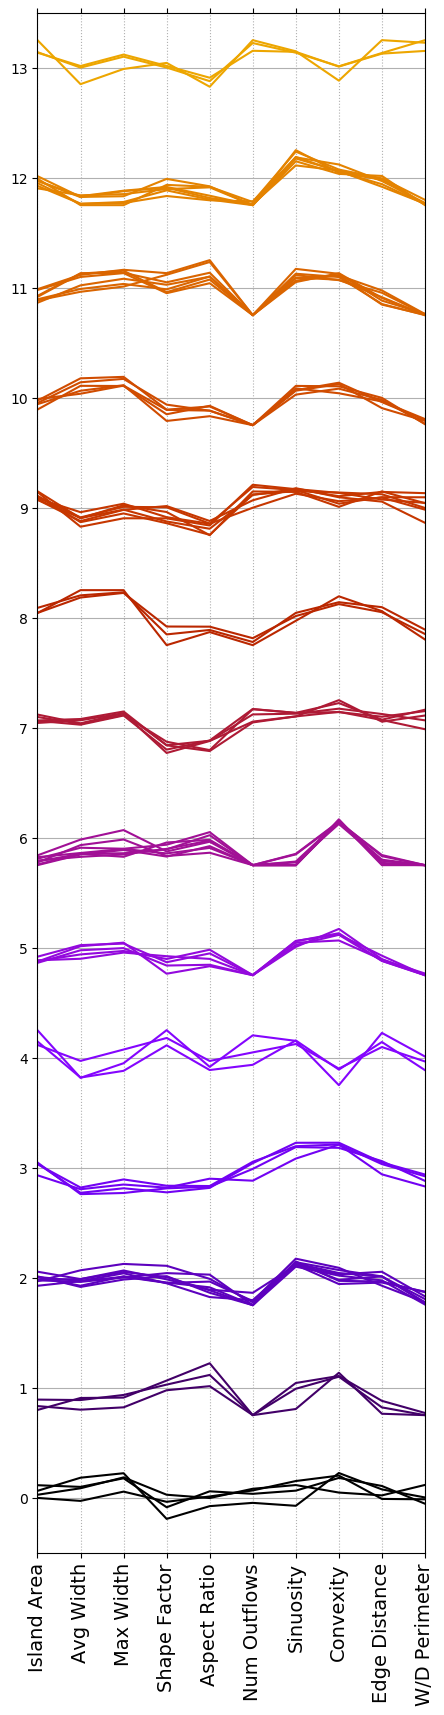

In [394]:
mpl.rcParams.update(mpl.rcParamsDefault)
cols = ['Island Area',
 'Avg Width',
 'Max Width',
 'Shape Factor',
 'Aspect Ratio',
 'Num Outflows',
 'Sinuosity',
 'Convexity',
 'Edge Distance',
 'W/D Perimeter']

fig, ax = plt.subplots(figsize=(5,20))

x = range(1,11)
dy = 0
cs = classes_df[good_loc].values
# cs = label_classes['geo_14']


import pylab
NUM_COLORS = max(cs) + 2

cm = pylab.get_cmap('gnuplot')


for c in np.unique(cs):

    loc = np.where(cs == c)[0]
    color = cm(1.*c/NUM_COLORS)
    
    for i in loc:

#         dy = dy + 0.25

        ax.plot(x,dy + data[i,:] - 0.5, '-', color = color)
#         ax.plot(x,dy + new_data.values[i,:]/10, '-', color = color, alpha = 0.5)
        
    dy += 2
    
ax.grid(True, axis='both')
ax.set_xticks(x);
ax.set_xticklabels(cols, fontdict={'fontsize': 14})
ax.set_yticks(range(0,dy,2))
ax.set_yticklabels(set(cs))

ax.xaxis.set_ticks_position('both')


for line in ax.get_xgridlines():
    line.set_linestyle(':')
    
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_ylim(-1,27)
ax.set_xlim(1,10)

plt.savefig('ganges_metrics/geosom_figs/_parallel_coordinates_13.png')

In [376]:
set(cs)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

71

In [297]:
data.shape

(72, 10)

In [974]:
# plot shapefiles within python

from descartes import PolygonPatch
import shapefile
import matplotlib.patches as mpatches


for l in ls:
    
    print l
    print '-'*10

    sf = shapefile.Reader('ganges_metrics/geosom_array/kmeans_classes_' + str(l) + '_' + str(l) + '.shp')

    fields = [f[0] for f in sf.fields[1:]]

    vals = {}
    colors = {}
    for n,field in enumerate(fields):
        vals[field] = [r.record[n] for r in sf.shapeRecords()]
        colors[field] = plt.cm.Spectral(np.array(vals[field]) / max(vals[field]))



    for n,field in enumerate(fields):
        
        print field

        fig = plt.figure(figsize=(20,20)) 
        ax = fig.gca() 

        for nn,poly in enumerate(sf.shapeRecords()):

            c = colors[field][nn]

            poly_geo=poly.shape.__geo_interface__
            ax.add_patch(PolygonPatch(poly_geo, fc=c, ec=c))



        filename = 'geosom_' + str(l) + '__kmeans_' + field + '.png'

        ax.axis('scaled')
        plt.title(filename[:-4])

        class_num = set(vals[field])
        handles = []

        for cn in class_num:
            color_val = colors[field][np.where(np.array(vals[field]) == cn)[0][0]]
            handles.append(mpatches.Patch(color=color_val, label=str(int(cn))))

        plt.legend(handles = handles, loc = 1, fontsize = 'xx-large', markerscale = 20)


        plt.savefig('ganges_metrics/geosom_figs/' + filename, dpi = 150)    
        plt.close()
    
    print '\n'

7
----------
geo_8
nogeo_10
geo_10
geo_7
geo_6
geo_5
nogeo_5
nogeo_6
geo_9
nogeo_9
nogeo_8
nogeo_7


9
----------
geo_8
nogeo_10
geo_10
geo_7
geo_6
geo_5
nogeo_5
nogeo_6
geo_9
nogeo_9
nogeo_8
nogeo_7


11
----------
geo_8
nogeo_10
geo_10
geo_7
geo_6
geo_5
nogeo_5
nogeo_6
geo_9
nogeo_9
nogeo_8
nogeo_7


13
----------
geo_8
nogeo_10
geo_10
geo_7
geo_6
geo_5
nogeo_5
nogeo_6
geo_9
nogeo_9
nogeo_8
nogeo_7


15
----------
geo_8
nogeo_10
geo_10
geo_7
geo_6
geo_5
nogeo_5
nogeo_6
geo_9
nogeo_9
nogeo_8
nogeo_7




In [991]:
geo_classes = pd.DataFrame()

ls = range(7,17,2)
# ls = range(9,13,2)
ls_count = range(len(ls)-1)

for l in ls:


    c = fiona.open('ganges_metrics/geosom_array/kmeans_classes_' + str(l) + '_' + str(l) + '.shp')    
    
    for k in c[0]['properties'].keys():
        geo_classes[str(l) + k] = [pol['properties'][k] for pol in c]
        
    c = None


In [992]:
pd_new_classes = pd.DataFrame()

columns_geo = ['geo_5','geo_6','geo_7','geo_8','geo_9','geo_10',]
columns_nogeo = ['nogeo_5', 'nogeo_6', 'nogeo_7', 'nogeo_8', 'nogeo_9', 'nogeo_10',]


# all columns
cols = geo_classes.columns.tolist()
n = len(cols) + 1

pd_new_classes['always_grouped'] = -1 * np.ones((1235,))
pd_persistent = geo_classes.duplicated(subset=cols[-n:])
indices_new_classes = list(geo_classes[~pd_persistent].index)

for nn,i in enumerate(indices_new_classes):
    pd_new_classes['always_grouped'][(geo_classes[cols[-n:]] == geo_classes[cols[-n:]].loc[i]).sum(axis=1) == len(cols[-n:])] = nn
    

# geo only
cols = []
for g in columns_geo:
    for l in ls:
        cols.append(str(l)+g)
        
pd_new_classes['grouped_geo'] = -1 * np.ones((1235,))
pd_persistent = geo_classes.duplicated(subset=cols[-n:])
indices_new_classes = list(geo_classes[~pd_persistent].index)

for nn,i in enumerate(indices_new_classes):
    pd_new_classes['grouped_geo'][(geo_classes[cols[-n:]] == geo_classes[cols[-n:]].loc[i]).sum(axis=1) == len(cols[-n:])] = nn
    
    
# geo only
cols = []
for g in columns_nogeo:
    for l in ls:
        cols.append(str(l)+g)
        
pd_new_classes['grouped_nogeo'] = -1 * np.ones((1235,))
pd_persistent = geo_classes.duplicated(subset=cols[-n:])
indices_new_classes = list(geo_classes[~pd_persistent].index)

for nn,i in enumerate(indices_new_classes):
    pd_new_classes['grouped_nogeo'][(geo_classes[cols[-n:]] == geo_classes[cols[-n:]].loc[i]).sum(axis=1) == len(cols[-n:])] = nn
    

pd_new_classes.columns = ['all', 'geo', 'nogeo']

for k in pd_new_classes.columns:

    print k
    
    count = pd_new_classes[k].value_counts()
    indices = count.index.tolist()
    values = count.values
    
    pd_new_classes[k + '_c'] = 0
    pd_new_classes[k + '_n'] = 0

    for n,i in enumerate(indices):
        
        v = values[n]
        pd_new_classes[k + '_n'].loc[pd_new_classes[k] == i] = v
        
        if v > 1:
            pd_new_classes[k + '_c'].loc[pd_new_classes[k] == i] = int(n)
        else:
            pd_new_classes[k + '_c'].loc[pd_new_classes[k] == i] = -int(n)
        



pd_new_classes.columns = ['all', 'geo', 'nogeo', 'all_c', 'geo_n', 'nogeo_c', 'all_n', 'geo_c', 'nogeo_n']


field_type = {}
for k in pd_new_classes.keys():
    field_type[k] = ogr.OFTInteger

create_shapefile_from_shapely_multi(shp_islands2,
                                    'ganges_metrics/geosom_array/pd_new_classes.shp',
                                    fields = pd_new_classes,
                                    field_type = field_type)

pd.to_pickle(pd_new_classes,'ganges_metrics/geosom_array/pd_new_classes.pickle')
pd.to_pickle(geo_classes,'ganges_metrics/geosom_array/geo_classes.pickle')

all
geo
nogeo


In [554]:
pd_new_classes = pd.read_pickle('ganges_metrics/geosom_array/pd_new_classes.pickle')

In [993]:
permanent_ids = (pd_new_classes['all_c'][pd_new_classes['all_c']>=0]).index.tolist()
permanent_groups = (pd_new_classes['all_c'][pd_new_classes['all_c']>=0]).values.tolist()


cols = geo_classes.columns.tolist()

p_classes = pd.DataFrame()
p_classes['class'] = -1 * np.ones((len(geo_classes),))

pd_persistent = geo_classes.duplicated()
indices_new_classes = list(geo_classes[~pd_persistent].index)

for nn,i in enumerate(indices_new_classes):
    p_classes['class'][(geo_classes == geo_classes.loc[i]).sum(axis=1) == len(cols)] = nn

a = geo_classes.loc[indices_new_classes]
# a = geo_classes
b = a.values

h,w = b.shape

eye = np.eye(w, dtype=bool)
corr = np.ones((h, h)) * w

for i, j in itertools.permutations(range(h), r = 2):

    mask = b[i][:,None] == b[j]
    out = mask[eye]

    corr[i,j] = out.sum()

corr_ = corr / float(w)

In [1004]:
a = geo_classes
# a = geo_classes
b = a.values

h,w = b.shape

eye = np.eye(w, dtype=bool)
corr = np.ones((h, h)) * w

for i, j in itertools.permutations(range(h), r = 2):

    mask = b[i][:,None] == b[j]
    out = mask[eye]

    corr[i,j] = out.sum()

corr_ = corr / float(w)

In [1011]:
df_corr = pd.DataFrame()

for i in range(len(corr_)):
    
    df_corr[str(i)] = corr_[i,:]

field_type = {}
for k in df_corr.keys():
    field_type[k] = ogr.OFTReal

create_shapefile_from_shapely_multi(shp_islands2,
                                    'ganges_metrics/geosom_array/correlation.shp',
                                    fields = df_corr,
                                    field_type = field_type)

In [995]:
ind_95 = np.where((corr_ >= 0.95) * (corr_ != 1)) # difference of 1
pairs_95 = [list(i) for i in set(frozenset(item) for item in zip(ind_95[0], ind_95[1]))]

ind_90 = np.where((corr_ >= 0.9) * (corr_ != 1)) # difference of 2
pairs_90 = [list(i) for i in set(frozenset(item) for item in zip(ind_90[0], ind_90[1]))]

ind_85 = np.where((corr_ >= 0.85) * (corr_ != 1)) # difference of 4
pairs_85 = [list(i) for i in set(frozenset(item) for item in zip(ind_85[0], ind_85[1]))]

ind_80 = np.where((corr_ >= 0.8) * (corr_ != 1)) # difference of ?
pairs_80 = [list(i) for i in set(frozenset(item) for item in zip(ind_80[0], ind_80[1]))]

ind_75 = np.where((corr_ >= 0.75) * (corr_ != 1)) # difference of ?
pairs_75 = [list(i) for i in set(frozenset(item) for item in zip(ind_75[0], ind_75[1]))]


p_classes['class95'] = p_classes['class']

for nn,i in enumerate(pairs_95):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class95'][p_classes['class'] == replace_ind] = new_ind

    
    
p_classes['class90'] = p_classes['class']

for nn,i in enumerate(pairs_90):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class90'][p_classes['class'] == replace_ind] = new_ind

    
    
    
p_classes['class85'] = p_classes['class']

for nn,i in enumerate(pairs_85):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class85'][p_classes['class'] == replace_ind] = new_ind
    
    
    
p_classes['class80'] = p_classes['class']

for nn,i in enumerate(pairs_80):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class80'][p_classes['class'] == replace_ind] = new_ind

    
    
    
p_classes['class75'] = p_classes['class']

for nn,i in enumerate(pairs_75):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class75'][p_classes['class'] == replace_ind] = new_ind

ind_70 = np.where((corr_ >= 0.70) * (corr_ != 1)) # difference of ?
pairs_70 = [list(i) for i in set(frozenset(item) for item in zip(ind_70[0], ind_70[1]))]

ind_65 = np.where((corr_ >= 0.65) * (corr_ != 1)) # difference of ?
pairs_65 = [list(i) for i in set(frozenset(item) for item in zip(ind_65[0], ind_65[1]))]

ind_60 = np.where((corr_ >= 0.60) * (corr_ != 1)) # difference of ?
pairs_60 = [list(i) for i in set(frozenset(item) for item in zip(ind_60[0], ind_60[1]))]

ind_55 = np.where((corr_ >= 0.55) * (corr_ != 1)) # difference of ?
pairs_55 = [list(i) for i in set(frozenset(item) for item in zip(ind_55[0], ind_55[1]))]

ind_50 = np.where((corr_ >= 0.50) * (corr_ != 1)) # difference of ?
pairs_50 = [list(i) for i in set(frozenset(item) for item in zip(ind_50[0], ind_50[1]))]



p_classes['class70'] = p_classes['class']

for nn,i in enumerate(pairs_75):
    
    new_ind = i[0]t
    replace_ind = i[1]
    p_classes['class70'][p_classes['class'] == replace_ind] = new_ind
    
    
p_classes['class65'] = p_classes['class']

for nn,i in enumerate(pairs_65):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class65'][p_classes['class'] == replace_ind] = new_ind
    
    

p_classes['class60'] = p_classes['class']

for nn,i in enumerate(pairs_60):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class60'][p_classes['class'] == replace_ind] = new_ind
    
    

p_classes['class55'] = p_classes['class']

for nn,i in enumerate(pairs_55):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class55'][p_classes['class'] == replace_ind] = new_ind
    
    
    
    

p_classes['class50'] = p_classes['class']

for nn,i in enumerate(pairs_50):
    
    new_ind = i[0]
    replace_ind = i[1]
    p_classes['class50'][p_classes['class'] == replace_ind] = new_ind

In [996]:
p_classes.apply(lambda x: len(x.unique()))

class      817
class95    689
class90    588
class85    527
class80    473
class75    454
class70    454
class65    426
class60    412
class55    399
class50    414
dtype: int64

In [972]:
# # component planes

# ls = range(7,17,2)

# for l in ls:

#     c = fiona.open('ganges_metrics/geosom_array/results_' + str(l) + '_' + str(l) + '.shp')
# #     c = fiona.open('ganges_metrics/geosom_array/results_' + str(o) + "_" + str(l) + '_' + str(l) + '.shp')
    
#     neurons = MultiPolygon([shape(pol['geometry']) for pol in c])
#     neuron_ID = [pol['properties']['ID'] for pol in c]
#     neuron_count = [pol['properties']['iter499'] for pol in c]
#     neuron_centroids = MultiPoint([s.centroid.coords[0] for s in neurons])
#     gt_zero = np.array(neuron_count) > 0
    
#     c = None


#     classes = np.loadtxt('ganges_metrics/geosom_array/areas_' + str(l) + '_' + str(l) + '.csv',
#                          delimiter = ';', dtype = 'int')
#     classes = classes[:,1]
#     new_classes = np.array(neuron_ID)[np.array(neuron_count) > 0][classes]
    
    
#     component_averages = np.zeros((len(neuron_ID), new_data.shape[1]))

#     for n,i in enumerate(neuron_ID):

#         inds = np.where(new_classes == i)[0]
#         data = new_data.iloc[inds]

#         component_averages[int(i),:] = np.mean(data, axis=0)

#         if len(inds) == 1:
#             component_averages[int(i),:] = data


#     # n_ID = np.array(neuron_ID).reshape((l,l))
#     # n_count = np.array(neuron_count).reshape((l,l))
#     # n_data = {}

#     # for n,i in enumerate(new_data.columns):
#     #     n_data[i] = np.array(component_averages[:,n]).reshape((l,l))




#     # https://glowingpython.blogspot.com/2012/04/k-means-clustering-with-scipy.html
#     kmeans_classes = {}
    
#     inds = np.where(~np.isnan(component_averages[:,0]))[0]

#     for geo in [True, False]:

#         for K in range(5,11):

#             # data generation
#             if geo:
#                 c = np.array(neuron_centroids).T
#                 data_ = np.hstack((component_averages.copy(), c.T))
#                 data_ = data_[~np.isnan(component_averages[:,0])].T
#                 label = 'geo_' + str(K)

#             else:
#                 data_ = component_averages[~np.isnan(component_averages[:,0])].T
#                 label = 'nogeo_' + str(K)

#             min_max_scaler = MinMaxScaler()
#             data = min_max_scaler.fit_transform(data_.T)

#             # computing K-Mean
#             classes_df = pd.DataFrame()

#             for i in range(20):
#                 centroids,inertia = kmeans(data, K, iter = 1500)
#                 classes_df[i],_ = vq(data, centroids)


#             new_classes_df = pd.DataFrame()
#             cols = classes_df.columns.tolist()

#             new_classes_df['class'] = -1 * np.ones((len(inds),))
#             pd_persistent = classes_df.duplicated()
#             indices_new_classes = list(classes_df[~pd_persistent].index)

#             for nn,i in enumerate(indices_new_classes):
#                 new_classes_df['class'][(classes_df == classes_df.loc[i]).sum(axis=1) == len(cols)] = nn
    
   
#             nclass = np.zeros((len(shp_islands2),), dtype = 'int')
    
#             for n,i in enumerate(inds):
#                 loc = new_classes == i
#                 nclass[loc] = new_classes_df['class'][n]

#             kmeans_classes[label] = nclass





#     kmeans_reclass = {}

#     for k in kmeans_classes.keys():

#         a = kmeans_classes[k]

#         ids = [a[0]]
#         new_a = a

#         while len(new_a) > 0:
#             new_a = [i for i in new_a if i not in ids]
#             try:
#                 ids.append(new_a[0])
#             except:
#                 pass


#         valid_ids = list(np.unique(a))
#         new_ids = np.zeros_like(a)

#         for n,i in enumerate(ids):
#             loc = a == i
#             new_ids[loc] = valid_ids[n]

#         kmeans_reclass[k] = new_ids



#     field_type = {}
#     for k in kmeans_classes.keys():
#         field_type[k] = ogr.OFTReal

#     create_shapefile_from_shapely_multi(shp_islands2,
#                                         'ganges_metrics/geosom_array/kmeans_classes_' + str(l) + '_' + str(l) + '.shp',
#                                         fields = kmeans_reclass,
#                                         field_type = field_type)

In [1079]:
# new_data.columns = ['Island_Area',
#  'Avg_Width',
#  'Max_Width',
#  'Shape_Factor',
#  'Aspect_Ratio',
#  'Num_Outflows',
#  'Sinuosity',
#  'Convexity',
#  'Edge_Distance',
#  'W_D_Perimeter']

# data correlation

import seaborn as sns
import matplotlib as mpl

def color_nan(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'white' if np.isnan(val) else 'black'
    return 'color: %s' % color

df = new_data.corr()

scalel = 0.4
scaleh = 1

cmap = 'YlGnBu'



mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


(df.round(2)
  .mask(mask)
.style
.background_gradient(cmap=cmap, low = scalel, high = scaleh)
.set_properties(**{'width': '70px'})
 .highlight_null(null_color='white')
 .applymap(color_nan))

# all_corr = df.values

,area,avg_width,max_width,w_shape,d_shape,asp_rat,out_numbr,s500,s1000,s1500,convex
area,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
avg_width,0.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_width,0.25,0.92,nan,nan,nan,nan,nan,nan,nan,nan,nan
w_shape,0.65,0.07,0.2,nan,nan,nan,nan,nan,nan,nan,nan
d_shape,0.19,-0.04,0.02,0.58,nan,nan,nan,nan,nan,nan,nan
asp_rat,-0.26,0.14,0.08,0.09,0.46,nan,nan,nan,nan,nan,nan
out_numbr,0.69,0,0.16,0.71,0.02,-0.2,nan,nan,nan,nan,nan
s500,0.37,-0.23,-0.21,0.17,0.16,-0.12,0.16,nan,nan,nan,nan
s1000,0.54,-0.14,-0.07,0.26,0.21,-0.19,0.25,0.65,nan,nan,nan
s1500,0.55,-0.09,-0.01,0.28,0.24,-0.19,0.26,0.47,0.77,nan,nan


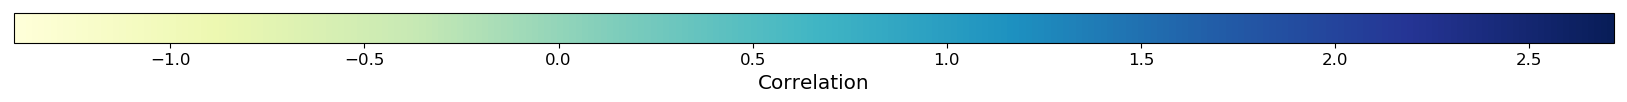

In [1003]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.02, 0.80, 2, 0.1])



norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Correlation', size='x-large')
ax1.tick_params(labelsize=12)
plt.show()

In [1057]:
import seaborn as sns
import matplotlib as mpl



z = 0
print 'Zone ' + str(z)
df = new_data[zone_cat == z].corr() - all_corr

scalel = 0.6
scaleh = 0.8

cmap = 'bwr_r'



def color_nan(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'white' if np.isnan(val) else 'black'
    return 'color: %s' % color

def highlight_max(data):
    cm = sns.diverging_palette(10, 240, n=9, as_cmap=True)
    
    d = (data.values.ravel()-(-0.2))/(0.2-(-0.2))

    hex_colors = [mpl.colors.rgb2hex(np.asarray(cm(v)[:3])) for v in d]
 
    colors = ['background-color: {}'.format(h) for h in hex_colors]
    return pd.DataFrame(np.asarray(colors).reshape(*data.shape),
                        index=data.index,
                        columns=data.columns)

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

(df.round(2)
 .mask(mask)
.style
.apply(highlight_max, axis=None)
.set_properties(**{'width': '70px'})
 .highlight_null(null_color='white')
 .applymap(color_nan)
)

# df_corr[z] = df.values

Zone0


,area,avg_width,max_width,w_shape,d_shape,asp_rat,out_numbr,s500,s1000,s1500,convex
area,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
avg_width,-0.48,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_width,-0.1,-0.2,nan,nan,nan,nan,nan,nan,nan,nan,nan
w_shape,0.05,-0.13,0.26,nan,nan,nan,nan,nan,nan,nan,nan
d_shape,0.22,0.07,0.34,0.25,nan,nan,nan,nan,nan,nan,nan
asp_rat,-0.12,0.28,0.21,-0.01,-0.08,nan,nan,nan,nan,nan,nan
out_numbr,0.1,-0.22,0.21,0.09,0.42,0.03,nan,nan,nan,nan,nan
s500,-0.01,0.04,0.06,-0.04,-0.04,-0,-0.01,nan,nan,nan,nan
s1000,0.11,-0.18,-0.05,0.03,-0.03,-0.19,0.08,-0.16,nan,nan,nan
s1500,0.16,-0.29,-0.11,0.07,-0.02,-0.21,0.13,-0.12,-0.04,nan,nan


In [1058]:
import seaborn as sns
import matplotlib as mpl



z = 1
print 'Zone ' + str(z)
df = new_data[zone_cat == z].corr() - all_corr

scalel = 0.6
scaleh = 0.8

cmap = 'bwr_r'



def color_nan(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'white' if np.isnan(val) else 'black'
    return 'color: %s' % color

def highlight_max(data):
    cm = sns.diverging_palette(10, 240, n=9, as_cmap=True)
    
    d = (data.values.ravel()-(-0.2))/(0.2-(-0.2))

    hex_colors = [mpl.colors.rgb2hex(np.asarray(cm(v)[:3])) for v in d]
 
    colors = ['background-color: {}'.format(h) for h in hex_colors]
    return pd.DataFrame(np.asarray(colors).reshape(*data.shape),
                        index=data.index,
                        columns=data.columns)

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

(df.round(2)
 .mask(mask)
.style
.apply(highlight_max, axis=None)
.set_properties(**{'width': '70px'})
 .highlight_null(null_color='white')
 .applymap(color_nan)
)

# df_corr[z] = df.values

Zone 1


,area,avg_width,max_width,w_shape,d_shape,asp_rat,out_numbr,s500,s1000,s1500,convex
area,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
avg_width,-0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_width,-0.04,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan
w_shape,-0.01,-0.06,-0.04,nan,nan,nan,nan,nan,nan,nan,nan
d_shape,0.11,0.04,0.02,0.13,nan,nan,nan,nan,nan,nan,nan
asp_rat,0.12,-0.01,-0.02,0.15,0.15,nan,nan,nan,nan,nan,nan
out_numbr,-0,-0.12,-0.09,-0.05,0.09,0,nan,nan,nan,nan,nan
s500,0.2,0.28,0.29,0.14,0.1,0.16,0.12,nan,nan,nan,nan
s1000,0.16,0.13,0.13,0.12,0.09,0.22,0.13,-0,nan,nan,nan
s1500,0.16,0,0.01,0.09,0.01,0.14,0.16,0.06,0.07,nan,nan


In [1059]:
import seaborn as sns
import matplotlib as mpl



z = 2
print 'Zone ' + str(z)
df = new_data[zone_cat == z].corr() - all_corr

scalel = 0.6
scaleh = 0.8

cmap = 'bwr_r'



def color_nan(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'white' if np.isnan(val) else 'black'
    return 'color: %s' % color

def highlight_max(data):
    cm = sns.diverging_palette(10, 240, n=9, as_cmap=True)
    
    d = (data.values.ravel()-(-0.2))/(0.2-(-0.2))

    hex_colors = [mpl.colors.rgb2hex(np.asarray(cm(v)[:3])) for v in d]
 
    colors = ['background-color: {}'.format(h) for h in hex_colors]
    return pd.DataFrame(np.asarray(colors).reshape(*data.shape),
                        index=data.index,
                        columns=data.columns)

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

(df.round(2)
 .mask(mask)
.style
.apply(highlight_max, axis=None)
.set_properties(**{'width': '70px'})
 .highlight_null(null_color='white')
 .applymap(color_nan)
)

# df_corr[z] = df.values

Zone 2


,area,avg_width,max_width,w_shape,d_shape,asp_rat,out_numbr,s500,s1000,s1500,convex
area,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
avg_width,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_width,-0.05,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan
w_shape,-0.01,0.03,-0.01,nan,nan,nan,nan,nan,nan,nan,nan
d_shape,-0.11,0.05,0.02,-0.06,nan,nan,nan,nan,nan,nan,nan
asp_rat,0.04,0.11,0.13,0.03,-0.01,nan,nan,nan,nan,nan,nan
out_numbr,-0,-0.02,-0.06,-0.02,-0.09,0.05,nan,nan,nan,nan,nan
s500,-0.12,-0.09,-0.13,-0.1,-0.06,-0.01,-0.09,nan,nan,nan,nan
s1000,-0.1,-0.04,-0.11,-0.13,-0.08,0.04,-0.12,-0.02,nan,nan,nan
s1500,-0.08,-0.03,-0.09,-0.12,-0.07,0.06,-0.12,0.01,-0.02,nan,nan


In [1060]:
import seaborn as sns
import matplotlib as mpl



z = 3
print 'Zone ' + str(z)
df = new_data[zone_cat == z].corr() - all_corr

scalel = 0.6
scaleh = 0.8

cmap = 'bwr_r'



def color_nan(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'white' if np.isnan(val) else 'black'
    return 'color: %s' % color

def highlight_max(data):
    cm = sns.diverging_palette(10, 240, n=9, as_cmap=True)
    
    d = (data.values.ravel()-(-0.2))/(0.2-(-0.2))

    hex_colors = [mpl.colors.rgb2hex(np.asarray(cm(v)[:3])) for v in d]
 
    colors = ['background-color: {}'.format(h) for h in hex_colors]
    return pd.DataFrame(np.asarray(colors).reshape(*data.shape),
                        index=data.index,
                        columns=data.columns)

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

(df.round(2)
 .mask(mask)
.style
.apply(highlight_max, axis=None)
.set_properties(**{'width': '70px'})
 .highlight_null(null_color='white')
 .applymap(color_nan)
)

# df_corr[z] = df.values

Zone 3


,area,avg_width,max_width,w_shape,d_shape,asp_rat,out_numbr,s500,s1000,s1500,convex
area,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
avg_width,0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_width,0.06,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan
w_shape,0.01,-0.04,-0.09,nan,nan,nan,nan,nan,nan,nan,nan
d_shape,-0.04,-0.09,-0.07,-0.13,nan,nan,nan,nan,nan,nan,nan
asp_rat,0.17,-0.08,-0.04,0.03,-0.06,nan,nan,nan,nan,nan,nan
out_numbr,-0.03,0.04,-0.02,-0.01,-0.12,0.11,nan,nan,nan,nan,nan
s500,-0.35,-0.25,-0.27,-0.17,-0.01,0.07,-0.18,nan,nan,nan,nan
s1000,-0.38,-0.24,-0.21,-0.17,0.08,0.11,-0.25,0.02,nan,nan,nan
s1500,-0.31,-0.06,-0.05,-0.13,0.1,0.11,-0.22,-0.19,-0.12,nan,nan


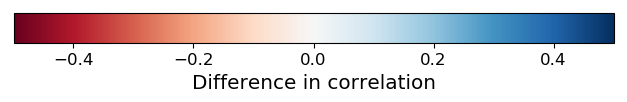

In [1067]:
fig = plt.figure(figsize=(3, 3))
ax1 = fig.add_axes([0.02, 0.80, 2, 0.1])

vmin = -0.5
vmax = 0.5

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap='RdBu',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Difference in correlation', size='x-large')
ax1.tick_params(labelsize=12)
plt.show()

In [554]:
# histograms of geosom grid-island map relationships

ls = range(5,19,2)

intersectBMU = {}
feasibleBMU = {}


for num,l in enumerate(ls):
    
    f, ax = plt.subplots(3, 2, figsize = (10,10))
    ax = ax.flatten()

    c = fiona.open('ganges_metrics/geosom_array/results_' + str(l) + '_' + str(l) + '.shp')
    
    neurons = MultiPolygon([shape(pol['geometry']) for pol in c])
    neuron_ID = [pol['properties']['ID'] for pol in c]
    neuron_count = [pol['properties']['iter999'] for pol in c]
#     neuron_centroids = MultiPoint([s.centroid.coords[0] for s in neurons])
#     gt_zero = np.array(neuron_count) > 0

    c = None
    
    intersectBMU = {}
    feasibleBMU = {}

    classes = np.loadtxt('ganges_metrics/geosom_array/areas_' + str(l) + '_' + str(l) + '.csv',
                         delimiter = ';', dtype = 'int')
    
    classes = classes[:,1]
    new_classes = np.array(neuron_ID)[np.array(neuron_count) > 0][classes]

    polys = shp_islands2
    for m,j in enumerate(polys):

        f = [n for n,i in enumerate(neurons) if j.intersects(i)]
        intersectBMU[m] = f

        ff = []
        for i in f:
            ff += [n for n,k in enumerate(neurons) if neurons[i].touches(k)]

        feasibleBMU[m] = list(set(f + ff))

    area_neuron = neurons[0].area

    area_island = np.zeros((len(shp_islands2),))
    area_influence = np.zeros((len(shp_islands2),))

    for n,i in enumerate(shp_islands2):

        area_island[n] = i.area
        area_influence[n] = len(feasibleBMU[n]) * area_neuron


    ratio_area_influence = area_island / area_influence

    ax[0].hist(np.log10(ratio_area_influence), bins = 100);
    ax[0].set_xlabel('log10 (island area / area of influence)')
    ax[0].set_title('GeoSOM ' + str(l) + 'x' + str(l));
    ax[0].set_xlim(-6,0)
    ax[0].set_ylim(0,40)
    
    ax[1].hist(neuron_count, bins = 10);
    ax[1].set_xlabel('Number of islands per class')
    
    
    
    number_possible_classes = [len(v) for v in feasibleBMU.values()]

    ax[2].hist(np.array(number_possible_classes) / float(len(neurons)), bins = 10);
    ax[2].set_xlabel('Fraction of neurons within island areas of influence')
    
#     import collections

    flat_classes = [w for v in intersectBMU.values() for w in v]
    islands_per_neuron = collections.Counter(flat_classes)

    ax[3].hist(islands_per_neuron.values(), bins = 20);
    ax[3].set_xlabel('Number of islands within neurons')
    
    flat_classes = [w for v in feasibleBMU.values() for w in v]
    islands_within_influence_area = collections.Counter(flat_classes)

    ax[4].hist(islands_within_influence_area.values(), bins = 20);
    ax[4].set_xlabel('Number of islands within influence of neurons')
    
    a = feasibleBMU.values()
    islands_with_same_influence_area = [a.count(i) for i in a]

    ax[5].hist(islands_with_same_influence_area, bins = 30);
    ax[5].set_xlabel('Number of islands with same influence area')
    
    plt.savefig('ganges_metrics/geosom_figs/hist_' + str(l) + '.png')
    plt.close()

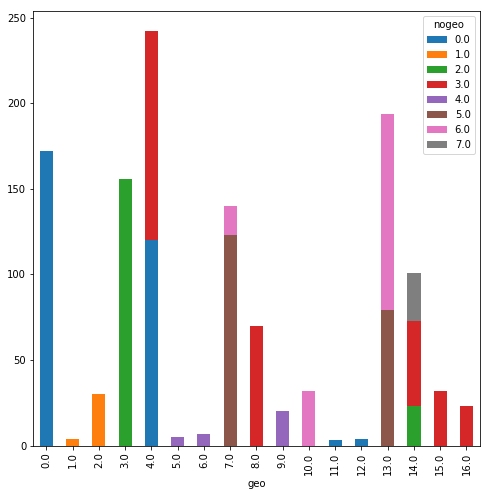

In [2912]:
tabs.plot(kind="bar", 
                 figsize=(8,8),

          stacked=True)

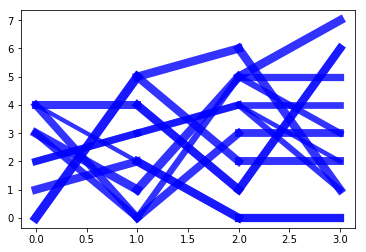

In [2913]:
edge_colors0 = plt.cm.viridis(np.arange(10) / 10.)


for num_class in range(3):

    tabs = pd.crosstab(pd_classes[columns_geo[num_class]], pd_classes[columns_geo[num_class+1]])
    vals = tabs.as_matrix()

    nodes = [int(i) + num_class*10 for i in list(tabs.index)] + [int(i) + (num_class+1)*10 for i in list(tabs.columns)]

    edges = []
    edge_width = []

    for r in range(vals.shape[0]):
        for c in range(vals.shape[1]):

            if vals[r,c] > 0:
                edges.append((r,c))
                edge_width.append(vals[r,c])

    ec = [e[0] for e in edges]
    edge_colors = ['b'] * len(ec)


    ec0 = [e[0] for e in edges]
    ec1 = [e[1] for e in edges]
    ec0c = [ec0.count(e) for e in ec0]
    ec1c = [ec1.count(e) for e in ec1]

    ids = [n for n in range(len(edges)) if (ec0c[n] == 1) and (ec1c[n] == 1)]

    for n,e in enumerate(edges):
        plt.plot([num_class,num_class+1], e, lw = np.log(edge_width[n] * 20), alpha = 0.8, c = edge_colors[n])
    
    for n in ids:
        plt.plot([num_class,num_class+1], edges[n], lw = np.log(edge_width[n] * 20), alpha = 0.5, c = edge_colors[n])
    

In [3022]:
edge_colors0 = plt.cm.viridis(np.arange(10) / 10.)

G = nx.Graph()

for num_class in range(5):

    tabs = pd.crosstab(pd_classes[columns_geo[num_class]], pd_classes[columns_geo[num_class+1]])
    vals = tabs.as_matrix()

    nodes = [int(i) + num_class*10 for i in list(tabs.index)] + [int(i) + (num_class + 1)*10 for i in list(tabs.columns)]

    edges = []
    edge_width = []

    for r in range(vals.shape[0]):
        for c in range(vals.shape[1]):

            if vals[r,c] > 5:
                edges.append((r + num_class*10, c + (num_class + 1)*10, {'weight': vals[r,c]}))
                edge_width.append(vals[r,c])

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

node_pos.append([int(i) + (num_class + 1)*10 for i in list(tabs.columns)])

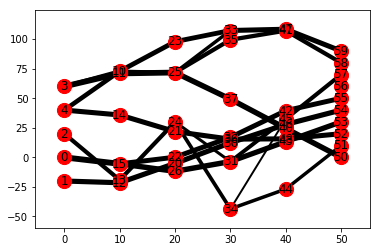

In [3023]:
node_position = {n:(n/10 * 10, n%10 * 10) for n in G.nodes if (n/10 * 10 == 0) or (n/10 * 10 == (num_class+1)*10)}
node_position[1] = (0, -20)
node_position[0] = (0, 0)
node_position[3] = (0, 60)
# node_position[36] = (30, 90)
# node_position[33] = (30, 40)
# node_position[34] = (30, 25)
# node_position[30] = (30, -20)
# node_position[31] = (30, 10)
# node_position[32] = (30, -5)

fixed_nodes = node_position.keys()
pos = nx.spring_layout(G, pos=node_position, fixed = fixed_nodes, k = 50)
for k in pos.keys():
    if (k >= 10) and (k < (num_class+1)*10):
        val = pos[k]
        pos[k] = (k/10 * 10, val[1])

# pos = nx.shell_layout(G, node_pos, center = (0,0), scale = 10)



pos[24] = (20, 30)

edgewidths = [np.log(e[2]) for e in G.edges(data='weight')]
nx.draw_networkx(G, pos=pos, node_size=200, width = edgewidths, 
                 with_labels = True, alpha =1, arrows = False)

5


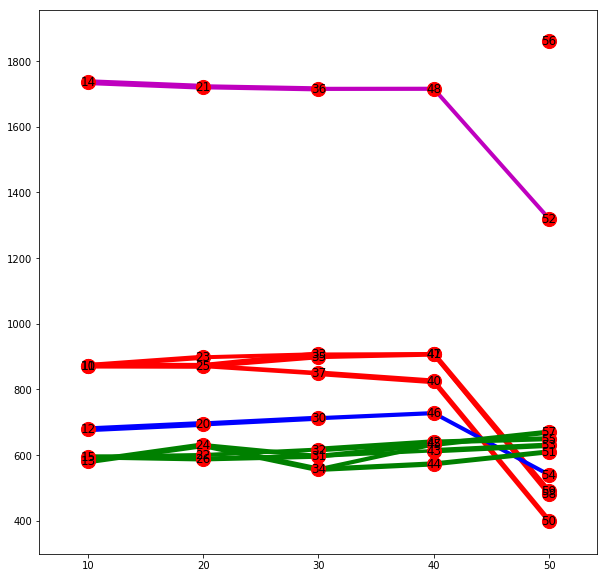

In [3031]:
plt.figure(figsize=(10,10))

gg = [n for n in G.nodes if n>=10]

cc = [n for n in nx.connected_components(G.subgraph(gg))]

print len(cc)

color = ['r', 'b', 'g', 'm', 'c']

for n in range(len(cc)):

    c = G.subgraph(cc[n])
    
    for cn in c.nodes():
        
        pos[cn] = (pos[cn][0], pos[cn][1] + n * 100)
    
    nx.draw_networkx(c, pos=pos, node_size=200, width = edgewidths, 
                 with_labels = True, alpha =1, arrows = False, edge_color = color[n])

In [105]:
geo_classes = pd.DataFrame()
geo_classes_area = pd.DataFrame()

ls = range(3,19,2)
ls_count = range(len(ls)-1)

for l in ls:

#     classes = np.loadtxt('ganges_metrics/geosom_array/areas_' + str(l) + '_' + str(l) + '.csv',
#                          delimiter = ';', dtype = 'int')[:,1]
    
#     geo_classes[l] = classes
    
    
    c = fiona.open('ganges_metrics/geosom_array/kmeans_classes_' + str(l) + '_' + str(l) + '.shp')
    
    class_dict = {}
    class_area_dict = {}
    
    for k in c[0]['properties'].keys()[0:1]:
        class_dict[k] = [pol['properties'][k] for pol in c]
        class_area_dict[k] = [shape(pol['geometry']).area for pol in c]
        
    c = None
    
    geo_classes[l] = class_dict['geo_8']
    geo_classes_area = class_area_dict['geo_8']

In [96]:
G = nx.Graph()

for num_class in ls_count[-1:]:#range(len(geo_classes.columns)-1):
    
    print num_class

    tabs = pd.crosstab(geo_classes[ls[num_class]], geo_classes[ls[num_class+1]])
    vals = tabs.as_matrix()

    nodes = [int(i) + num_class*500 for i in list(tabs.index)] + [int(i) + (num_class + 1)*500 for i in list(tabs.columns)]

    edges = []
    edge_width = []

    for r in range(vals.shape[0]):
        for c in range(vals.shape[1]):

            if vals[r,c] > 15:
                edges.append((r + num_class*500, c + (num_class + 1)*500, {'weight': vals[r,c]}))
                edge_width.append(vals[r,c])

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)



6


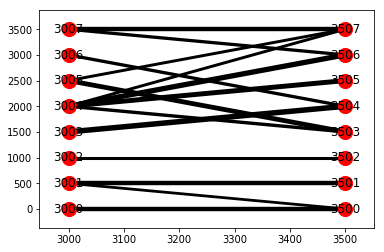

In [97]:
node_position = {n:(n/500 * 500, n%500 * 500) for n in G.nodes if (n/500 * 500 == num_class * 500) or (n/500 * 500 == (num_class+1)*500)}


fixed_nodes = node_position.keys()
pos = nx.spring_layout(G, pos=node_position, fixed = fixed_nodes, k = 1000)
for k in pos.keys():
    if (k >= 500) and (k < (num_class+1)*500):
        val = pos[k]
        pos[k] = (k/500 * 500, val[1])

# pos = nx.shell_layout(G, node_pos, center = (0,0), scale = 10)



edgewidths = [np.log(e[2]) for e in G.edges(data='weight')]
nx.draw_networkx(G, pos=pos, node_size=200, width = edgewidths, 
                 with_labels = True, alpha =1, arrows = False)

4


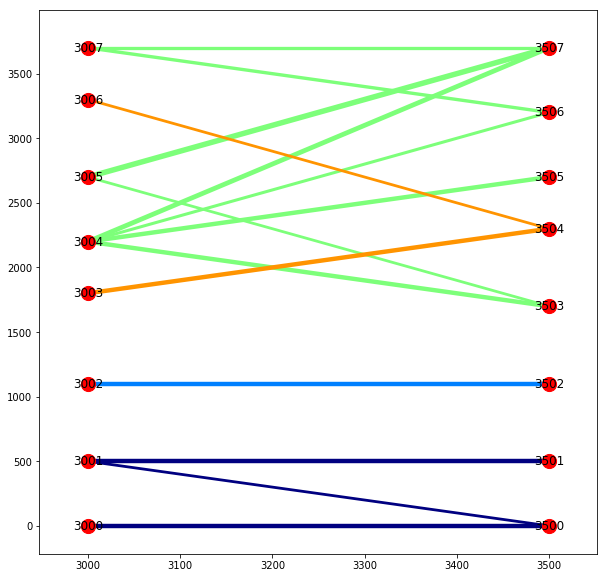

In [98]:
plt.figure(figsize=(10,10))

gg = [n for n in G.nodes]

cc = [n for n in nx.connected_components(G.subgraph(gg))]

print len(cc)

color = [matplotlib.colors.rgb2hex(list(i)) for i in plt.cm.jet(np.arange(len(cc))/float(len(cc)))]

for n in range(len(cc)):

    c = G.subgraph(cc[n])
    
    for cn in c.nodes():
        
        pos[cn] = (pos[cn][0], pos[cn][1] + n * 100)
    
    nx.draw_networkx(c, pos=pos, node_size=200, width = edgewidths, 
                 with_labels = True, alpha =1, arrows = False, edge_color = color[n])

In [66]:
tabs

15,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
13,,,,,,,,
0.0,96,6,6,2,10,0,0,0
1.0,5,91,0,0,0,1,0,2
2.0,1,1,36,0,9,3,0,0
3.0,2,10,2,0,14,119,0,6
4.0,4,0,0,187,2,2,0,4
5.0,0,0,0,25,329,27,1,32
6.0,0,0,0,39,13,0,29,0
7.0,0,0,0,3,27,19,0,70


Optimal k is:  44


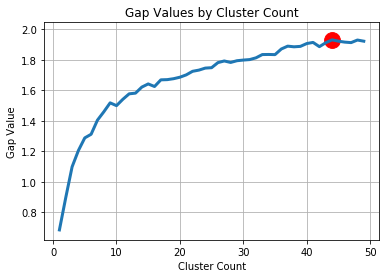

In [372]:
# https://anaconda.org/milesgranger/gap-statistic/notebook

%matplotlib inline
import time
import hashlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs


def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, gapdf = optimalK(data, nrefs = 5, maxClusters=50)
print 'Optimal k is: ', k

plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


In [2506]:

from circos import CircosPlot
import networkx as nx

In [2545]:
vals = tabs.as_matrix()

nodes = ['n' + str(int(i)) for i in list(tabs.columns)] + ['g' + str(int(i)) for i in list(tabs.index)]

edges = []

for r in range(vals.shape[0]):
    for c in range(vals.shape[1]):
        
        if vals[r,c] > 0:
            edges.append(('g' + str(r), 'n' + str(c)))
        
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

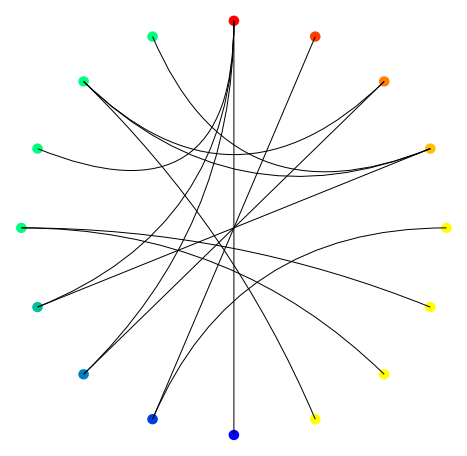

In [2576]:
nodecolors = np.vstack((plt.cm.autumn(np.array(tabs.index) / float(0.5*len(tabs.index))),
                        plt.cm.winter(np.array(tabs.columns) / float(0.5*len(tabs.columns)))))

c = CircosPlot(nodes, edges, 10,
               nodecolor = nodecolors,
               edgecolor = 'k',
               #edgeprops=edgeprops,
               #nodeprops=nodeprops
              )

c.draw()

In [2586]:
data[0]

array([0, 0, 0, 0])

In [1718]:
neuron_count0 = np.array([pol['properties']['iter999'] for pol in c])
diff = np.zeros((999,))


for n in np.arange(998,-1,-1):

    print n
    
    neuron_count1 = np.array([pol['properties']['iter' + str(n)] for pol in c])
    
    diff[n] = np.mean(neuron_count0 - neuron_count1)
    
    neuron_count0 = neuron_count1.copy()
    
    
    

# geographic distance between the final BMU and BMUs during training

neuron_count0 = np.array([pol['properties']['iter999'] for pol in c])
diff = np.zeros((sum(gt_zero), 999), dtype = 'int')


for n in np.arange(998,-1,-20):

    print n
    
    neuron_count1 = np.array([pol['properties']['iter' + str(n)] for pol in c]).astype('int')
    diff[:,n] = neuron_count1[gt_zero]

998
978
958
938
918
898
878
858
838
818
798
778
758
738
718
698
678
658
638
618
598
578
558
538
518
498
478
458
438
418
398
378
358
338
318
298
278
258
238
218
198
178
158
138
118
98
78
58
38
18


In [1294]:
neuron_density = np.array(neuron_count).reshape((l,l))

neuron_density[neuron_density == 0] = np.nan

plt.imshow(neuron_density, cmap = 'copper_r')
plt.title('Island count per neuron')
plt.colorbar()

# distances between element boundaries and unit in matrix
neuron_centroids = MultiPoint([s.centroid.coords[0] for s in neurons])
mean_distances = np.zeros((len(neuron_ID),))

for n,i in enumerate(neuron_ID):
    
    inds = np.where(new_classes == i)[0]
    mean_distances[n] = np.mean([shp_islands2[p].distance(neurons[int(i)]) for p in inds])

umatrix_dist_to_unit = mean_distances.reshape((l,l))

# mean distance between elements in class

import itertools

mean_distances = np.zeros((len(neuron_ID),))

for n,i in enumerate(neuron_ID):
    
    inds = np.where(new_classes == i)[0]
    if len(inds) > 0:
    
        b = MultiPoint([shp_islands2[i].centroid for i in inds])
        mean_distances[n] = np.sum([b[p1].distance(b[p2]) for p1, p2 in itertools.combinations(range(len(b)), 2)]) / len(b)

    if len(inds) == 0:
        
        mean_distances[n] = np.nan
        
    umatrix_dist_btw_elements = mean_distances.reshape((l,l))

centroids = []
mean_distances = np.zeros((len(neuron_ID),))

for n,i in enumerate(neuron_ID):
    
    inds = np.where(new_classes == i)[0]

    if len(inds) > 0:
        
        c = MultiPolygon([shp_islands2[p] for p in inds]).centroid.coords[0]
    
        centroids.append(c)
        mean_distances[n] = Point(c).distance(neuron_centroids[int(i)])
        
    else:
        
        mean_distances[n] = np.nan
        
        centroids.append(None)
        
umatrix_dist_centroid_to_unit = mean_distances.reshape((l,l))

In [474]:
# pts_props = []
pts_utm = []

for n in range(len(shp_islands2)):

    s = shp_islands2[n]
    
    if not s.is_valid:
        s = Polygon(s.exterior.simplify(1000))
    
    interval = 4000
    pts = RegularGridSampling(s, x_interval = interval, y_interval= interval)
    
    while (len(pts) < 10) & (interval > 500):
        interval -= 500
        pts = RegularGridSampling(s, x_interval = interval, y_interval= interval)
        
        if (len(pts) < 10) & (interval == 500):
            break

    while len(pts) < 10:    
        interval -= 100
        if interval > 0:
            pts = RegularGridSampling(s, x_interval = interval, y_interval= interval)
        else:
            break
            

    
    pts_utm.append([list(p.coords[0]) for p in pts])

#     pts_props.append([list(new_data.iloc[n]) for i in range(len(pts_utm))])


pts_num = [len(n) for n in pts_utm]
end_inds = np.cumsum(pts_num)

pts_props = np.zeros((sum(pts_num), len(new_data.columns)))

pts_props[0:end_inds[0],:] = new_data.iloc[0]

for i in range(1,len(end_inds)):    
    pts_props[end_inds[i-1]:end_inds[i],:] = new_data.iloc[i]

pts_props_x = (pts_props - pts_props.min(0)) / pts_props.ptp(0)
many_pt_data = pd.DataFrame(pts_props_x, columns = new_data.columns)

pts_utm = MultiPoint([i for sublist in pts_utm for i in sublist])

field_type = {}

for k in new_data.columns:
    field_type[k] = ogr.OFTReal


create_shapefile_from_shapely_multi(MultiPolygon([p.buffer(100) for p in pts_utm]),
                                    'ganges_metrics/metrics_results/new_islands_properties_pts_full.shp',
                                    fields = many_pt_data,
                                    field_type = field_type)

In [252]:
import clusterpy

params = new_data.columns

calif = clusterpy.importArcData("ganges_metrics/metrics_results/new_islands_properties");
calif.cluster("geoSom", params, nRows=20, nCols=20, wType="rook", fileName = 'ganges_metrics/geosom/results');
calif.exportArcData("ganges_metrics/geosom/new_islands_3_2")

# calif = None


Loading ganges_metrics/metrics_results/new_islands_properties.dbf
Loading ganges_metrics/metrics_results/new_islands_properties.shp


KeyboardInterrupt: 

In [220]:
calif.areas

KeyboardInterrupt: 

In [208]:
calif.results[0].exportArcData("ganges_metrics/geosom/new_islands_3_2_res")


Writing ESRI files
Writing DBF file
Done
ESRI files created


Writing ESRI files
Writing DBF file
Done
ESRI files created


In [179]:
c = calif.areas[0][0]

centroids = pd.DataFrame(c, columns = ['x','y'])

field_type = {}

for k in ['x','y']:
    field_type[k] = ogr.OFTReal


create_shapefile_from_shapely_multi(MultiPolygon([p.buffer(500) for p in MultiPoint(c)]),
                                    'ganges_metrics/geosom/centroids.shp',
                                    fields = centroids,
                                    field_type = field_type)



In [178]:
c

[[(591632.660843282, 2742390.829913143),
  (591632.660843282, 2742618.829913143),
  (591604.160843282, 2742618.829913143),
  (591604.160843282, 2742932.329913143),
  (591575.660843282, 2742932.329913143),
  (591575.660843282, 2743245.829913143),
  (591547.160843282, 2743245.829913143),
  (591547.160843282, 2743616.329913143),
  (591518.660843282, 2743616.329913143),
  (591518.660843282, 2743901.329913143),
  (591547.160843282, 2743901.329913143),
  (591547.160843282, 2744186.329913143),
  (591575.660843282, 2744186.329913143),
  (591575.660843282, 2744271.829913143),
  (591547.160843282, 2744271.829913143),
  (591547.160843282, 2744442.829913143),
  (591518.660843282, 2744442.829913143),
  (591518.660843282, 2744499.829913143),
  (591490.160843282, 2744499.829913143),
  (591490.160843282, 2744528.329913143),
  (591461.660843282, 2744528.329913143),
  (591461.660843282, 2744556.829913143),
  (591433.160843282, 2744556.829913143),
  (591433.160843282, 2744841.829913143),
  (591461.660843

In [ ]:
fields = {}    
for n,f in enumerate(all_keys):
    fields[f] = island_prop_array[:,n]
    
# for n,f in enumerate(params):
#     fields[f] = island_prop_array[:,n]


create_shapefile_from_shapely_multi(shp_islands2,
                                    'ganges_metrics/metrics_results/islands_properties_pts.shp',
                                    fields = fields,
                                    field_type = field_type)

zone_cat = np.array([zone_cat[i] for i in range(len(zone_cat)) if i not in bad_islands])

In [24]:

def plot_histograms(quant, label, masks, bin_min, bin_max, dbin, alt_mask = None):

                    
    if alt_mask is None:
                    
        alt_mask = np.ones_like(quant) > 0
    
    nbins = np.arange(bin_min, bin_max + 2*dbin, dbin)

    q_vals = []

    for i in range(len(masks)):

        vals, bins = np.histogram(quant[masks[i] * alt_mask], bins = nbins, normed = True);
        q_vals.append(vals)

    q_bins = bins

    plt.figure()
    plt.hist(quant[alt_mask], bins = nbins, normed=True,  fc = '0.75')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[0], 'r', label = 'Inactive')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[1], 'c', label = 'Fluvial')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[2], 'b', label = 'Tidal')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[3], 'g', label = 'Sundarbans')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[4], 'k--', label = 'North')
    plt.plot(q_bins[:-1] + dbin/2., q_vals[5], 'm--', label = 'South')
    plt.legend()
    
    
    plt.savefig('ganges_metrics/histograms2/' + label + '.png')
    plt.close()
    
    return

def plot_cdfs(quant, label, masks, alt_mask = None):

                    
    if alt_mask is None:
                    
        alt_mask = np.ones_like(quant) > 0
    
    cdf_vals = []
    cdf_bins = []

    for i in range(6):

        v, b = get_CDF(quant[masks[i] * alt_mask])
        cdf_vals.append(v)
        cdf_bins.append(b)


    plt.figure()
    plt.loglog(cdf_vals[0], cdf_bins[0], 'r', label = 'Inactive')
    plt.loglog(cdf_vals[1], cdf_bins[1], 'c', label = 'Fluvial')
    plt.loglog(cdf_vals[2], cdf_bins[2], 'b', label = 'Tidal')
    plt.loglog(cdf_vals[3], cdf_bins[3], 'g', label = 'Sundarbans')
    plt.loglog(cdf_vals[4], cdf_bins[4], 'k--', lw=2, label = 'North')
    plt.loglog(cdf_vals[5], cdf_bins[5], 'm--', lw=2, label = 'South')
    
    
    v,b = get_CDF(quant[alt_mask])
    plt.loglog(v,b, 'k:', lw = 2, label = 'All')
    
    plt.legend()
    
    plt.savefig('ganges_metrics/histograms2/' + label + '.png')
    plt.close()
    
    return

In [1198]:
# get metric histograms

# masks
m0 = zone_cat == 0
m1 = zone_cat == 1
m2 = zone_cat == 2
m3 = zone_cat == 3
masks = [m0, m1, m2, m3, m0 + m1, m2 + m3]

alt_mask = fields['p_area'] > 100000.

q = 'perimeter'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 10, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 16, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'aspt_ratio'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'major_axis'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'shp_factor'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.125
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'minor_axis'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'edge_dist'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin1500'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin1000'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'sin500'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.1, 0.5, 0.02
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'avg_width'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 6, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'max_width'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 8, 0.25
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_wetperim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_p_eq_dia'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_perim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_major_ax'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 10, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_wetperim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_eq_a_dia'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 9, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_ch_area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_minor_ax'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 7, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_solidity'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1.5, 0.05
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_ch_perim'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 7, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_d_shapef'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 1.5, 0.1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_w_shapef'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 1.5, 0.1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_area'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 14, 0.5
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_circ'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1, 0.1
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_asp_rat'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 3, 0.2
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_orient'
quant = fields[q]
bin_min, bin_max, dbin = 0, 180, 10
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_concav'
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -1, 16, 1
plot_histograms(quant, 'log__' + q + '_min_' + q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'p_convex'
quant = fields[q]
bin_min, bin_max, dbin = 0, 1, 0.1
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)



q = 'ch_ang_std'
quant = fields[q]
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_min'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_max'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'ch_ang_med'
quant = np.array([f if f <= 180 else 360 - f for f in fields[q]])
bin_min, bin_max, dbin = 0, 180, 15
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)




alt_mask *= (fields['out_numbr'] > 1)

q = 'o_ang_std'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_min'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_max'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_med'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'o_ang_mean'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)

q = 'out_numbr'
quant = fields[q]
bin_min, bin_max, dbin = 0, 90, 5
plot_histograms(quant, q, masks, bin_min, bin_max, dbin, alt_mask)



# get metric cdf

# masks
m0 = zone_cat == 0
m1 = zone_cat == 1
m2 = zone_cat == 2
m3 = zone_cat == 3
masks = [m0, m1, m2, m3, m0 + m1, m2 + m3]

# alt_mask = fields['p_area'] > 100000.

q = 'perimeter'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)
          
q = 'area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'aspt_ratio'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'major_axis'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'shp_factor'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'minor_axis'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'edge_dist'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin1500'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin1000'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'sin500'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'avg_width'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'max_width'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_wetperim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_p_eq_dia'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_perim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_major_ax'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_wetperim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_eq_a_dia'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_ch_area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_minor_ax'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_solidity'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_ch_perim'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_d_shapef'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_w_shapef'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_area'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_circ'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_asp_rat'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_orient'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_concav'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)

q = 'p_convex'
quant = (fields[q] / fields[q].min())
plot_cdfs(quant, q, masks)



q = 'ch_ang_std'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_min'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_max'
quant = fields[q]
plot_cdfs(quant, q, masks)

q = 'ch_ang_med'
quant = fields[q]
plot_cdfs(quant, q, masks)




alt_mask = (fields['out_numbr'] > 1)

q = 'o_ang_std'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_min'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_max'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_med'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'o_ang_mean'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)

q = 'out_numbr'
quant = fields[q]
plot_cdfs(quant, q, masks, alt_mask)



In [1891]:
c = fiona.open('testOutput/geoSom_test4.shp')

geosom4 = MultiPolygon([shape(pol['geometry']) for pol in c])
geosom4_cat = np.array([line['properties']['geoSom_2018'] for line in c])
geosom4_id = [line['properties']['id'] for line in c]

from matplotlib.cm import get_cmap

cmap = get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba) # (0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)



def plot_histograms_geosom(quant, q1, label, label2, masks, bin_min, bin_max, dbin, cmap):

    
    f, axes = plt.subplots(1, 2, figsize = (15, 5))
    
    nbins = np.arange(bin_min, bin_max + 2*dbin, dbin)
    
    
    axes[0].hist(quant, bins = nbins,  normed = True, fc = '0.5', edgecolor = '0.1')
    
    label_txt = range(len(masks))

    for i in range(len(masks)):

        c = cmap(float(i)/len(masks))
        vals, bins = np.histogram(quant[masks[i]], normed = True, bins = nbins);
        axes[0].plot(bins[:-1] + dbin/2., vals, c = c, label = str(label_txt[i]), lw = 2)
    
    axes[0].legend()
    axes[0].set_xlabel(label)
    axes[0].set_facecolor('0.1')
    
    
    v,b = get_CDF(q1)
    axes[1].loglog(v,b, 'w:', lw = 2, label = 'All')

    for i in range(len(masks)):

        v,b = get_CDF(q1[masks[i]])
        c = cmap(float(i)/len(masks))
        
        axes[1].loglog(v, b, c = c, label = str(label_txt[i]), lw = 2)
        
        
    axes[1].legend() 
    
    axes[1].set_xlabel(label2) 
    axes[1].set_facecolor('0.1')
    plt.savefig('ganges_metrics/geosom/test4/' + label + '.png')
    plt.close()
    
    
    
    
    return

In [1892]:
# masks

masks = []
for i in range(int(geosom4_cat.max() + 1)):
    
    masks.append(geosom4_cat == i)


params = ['p_area', 'p_w_shapef', 'p_asp_rat', 'p_num_ox', 'edge_dist', 'max_width', 'avg_width']


q = 'p_area'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 14, 0.5
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)

q = 'p_w_shapef'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 2, 0.1
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)

q = 'p_asp_rat'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 3, 0.1
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)

q = 'p_num_ox'
q1 = fields[q]
quant = fields[q]
bin_min, bin_max, dbin = -1, 47, 1
plot_histograms_geosom(quant, q1, q, q, masks, bin_min, bin_max, dbin, cmap)

q = 'edge_dist'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 6, 0.25
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)

q = 'max_width'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 6, 0.25
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)


q = 'avg_width'
q1 = fields[q]
quant = np.log(fields[q] / fields[q].min())
bin_min, bin_max, dbin = -0.5, 5, 0.2
plot_histograms_geosom(quant, q1, 'log__' + q + '_min_' + q, q, masks, bin_min, bin_max, dbin, cmap)


In [1910]:
num_islands = [sum(m) for m in masks]
columns = ['min', 'mean', 'median', 'max', 'std', 'sum']

In [1918]:
quant_area = []

for m in masks:

    q = 'p_area'
    q1 = fields[q]
    quant = q1[m]

    quant_area.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_area, columns = columns)

,min,mean,median,max,std,sum
0,1.545622e+08,4.009508e+08,3.283249e+08,7.925911e+08,2.601823e+08,1.603803e+09
1,1.868175e+04,9.477634e+06,3.894739e+05,1.234847e+08,2.099855e+07,1.023584e+09
2,2.193075e+04,2.673057e+06,4.248068e+05,2.365841e+07,4.453783e+06,1.871140e+08
3,5.604525e+04,1.587635e+06,9.612979e+05,4.805271e+06,1.479498e+06,1.682893e+08
4,2.165840e+08,1.362661e+09,1.031225e+09,5.408443e+09,1.345999e+09,2.180258e+10
5,1.462050e+04,1.159650e+08,7.740742e+07,7.648633e+08,1.608066e+08,9.625092e+09
6,3.086550e+04,1.807878e+07,9.454590e+06,1.152965e+08,2.243394e+07,1.862115e+09
7,2.274300e+04,3.221677e+06,1.918128e+06,1.056656e+07,3.038038e+06,5.090249e+08
8,1.148221e+08,2.439471e+08,1.612462e+08,4.703699e+08,1.307303e+08,1.707630e+09
9,4.548600e+04,5.636392e+07,3.682092e+07,6.738369e+08,9.769092e+07,8.736407e+09


In [1917]:
quant_shape = []

for m in masks:

    q = 'p_w_shapef'
    q1 = fields[q]
    quant = q1[m]

    quant_shape.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_shape, columns = columns)

,min,mean,median,max,std,sum
0,9.791110,11.626061,11.578455,13.556223,1.351586,46.504243
1,4.618802,6.725226,6.043021,12.956866,1.734920,726.324385
2,4.478324,6.643440,6.183903,10.564501,1.560921,465.040815
3,4.646543,6.753542,6.239419,13.045909,1.805944,715.875499
4,5.985107,14.944074,14.455646,33.039933,6.482086,239.105181
5,4.442128,8.149397,7.620571,15.063349,2.311359,676.399980
6,4.702622,6.840267,6.577287,11.795854,1.489528,704.547499
7,4.481663,6.577642,6.062062,12.396128,1.563918,1039.267402
8,7.888340,12.239578,12.406755,17.122798,3.367858,85.677043
9,4.701800,8.298411,7.700620,16.486410,2.550236,1286.253778


In [1916]:
quant_asp = []

for m in masks:

    q = 'p_asp_rat'
    q1 = fields[q]
    quant = q1[m]

    quant_asp.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_asp, columns = columns)

,min,mean,median,max,std,sum
0,1.322685,3.113552,2.586609,5.958306,1.808232,12.454209
1,1.025622,2.678239,2.448993,6.979121,1.104923,289.249766
2,1.005981,2.871484,2.407843,10.785523,1.660581,201.003885
3,1.017573,2.609737,2.202644,7.350000,1.235300,276.632095
4,1.187110,2.150367,2.113084,3.779852,0.642690,34.405878
5,1.013847,2.610661,2.129067,7.611111,1.465884,216.684894
6,1.005275,1.853240,1.716615,4.790325,0.675019,190.883671
7,1.018519,2.885116,2.553251,11.568898,1.601491,455.848306
8,1.502011,1.936242,1.923985,2.680147,0.383300,13.553696
9,1.017795,2.112071,1.909100,5.437908,0.819254,327.371061


In [1915]:
quant_ox = []

for m in masks:

    q = 'p_num_ox'
    q1 = fields[q]
    quant = q1[m]

    quant_ox.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_ox, columns = columns)

,min,mean,median,max,std,sum
0,1.0,1.250000,1.0,2.0,0.433013,5.0
1,0.0,0.027778,0.0,1.0,0.164336,3.0
2,0.0,0.028571,0.0,1.0,0.166599,2.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,7.187500,1.5,46.0,11.673789,115.0
5,0.0,0.192771,0.0,3.0,0.590238,16.0
6,0.0,0.000000,0.0,0.0,0.000000,0.0
7,0.0,0.006329,0.0,1.0,0.079304,1.0
8,0.0,0.142857,0.0,1.0,0.349927,1.0
9,0.0,0.032258,0.0,1.0,0.176685,5.0


In [1914]:
quant_edge = []

for m in masks:

    q = 'edge_dist'
    q1 = fields[q]
    quant = q1[m]

    quant_edge.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_edge, columns = columns)

,min,mean,median,max,std,sum
0,105.536723,150.143144,145.120417,204.795019,37.786058,600.572578
1,2.000000,20.184799,8.365746,121.165177,26.803465,2179.958289
2,2.000000,12.952738,8.031129,54.203321,11.498982,906.691655
3,2.000000,13.235117,11.852350,31.000000,7.180396,1402.922406
4,122.576507,204.768864,186.047770,470.034041,82.880711,3276.301827
5,1.414214,70.858187,54.918121,239.083667,64.871675,5881.229483
6,2.236068,37.034314,29.966648,119.553335,24.722801,3814.534342
7,2.000000,18.275962,16.383916,45.177428,11.150664,2887.602057
8,89.442719,113.800770,111.986606,143.961800,17.397427,796.605390
9,2.236068,49.084088,44.777226,168.439900,31.133387,7608.033644


In [1913]:
quant_maxwidth = []

for m in masks:

    q = 'max_width'
    q1 = fields[q]
    quant = q1[m]

    quant_maxwidth.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
    
pd.DataFrame(quant_maxwidth, columns = columns)

,min,mean,median,max,std,sum
0,445.184235,1472.969124,1638.098450,2170.495361,685.692746,5891.876495
1,57.000000,747.664809,556.796174,2579.525391,626.284545,80747.799333
2,57.000000,820.409394,748.141571,4156.312500,731.785506,57428.657558
3,57.000000,2185.777594,1480.823791,8344.029297,2055.171684,231692.424968
4,127.455879,2218.588560,565.716187,20425.175781,4866.087679,35497.416954
5,57.000000,728.277328,360.499664,8758.175781,1223.514663,60447.018264
6,57.000000,683.229241,205.516418,6424.584961,1141.305358,70372.611783
7,57.000000,2608.303455,1975.360352,15784.987305,2736.848167,412111.945949
8,127.455879,2365.511476,1377.467285,8256.150391,2548.856452,16558.580330
9,57.000000,2334.031211,1359.662109,12153.169922,2556.919652,361774.837661


In [1912]:
quant_avgwidth = []

for m in masks:

    q = 'avg_width'
    q1 = fields[q]
    quant = q1[m]

    quant_avgwidth.append([quant.min(), quant.mean(), np.median(quant), quant.max(), quant.std(), quant.sum()])
    
pd.DataFrame(quant_avgwidth, columns = columns)

,min,mean,median,max,std,sum
0,84.265567,227.709490,225.785467,375.001460,110.122606,910.837961
1,57.000000,297.056933,253.843237,857.314954,194.524982,32082.148752
2,57.000000,363.221277,302.447005,1702.854580,294.675220,25425.489424
3,57.000000,737.742757,506.990792,4516.317119,787.265085,78200.732192
4,61.079981,599.541887,94.161928,7212.312854,1716.672213,9592.670192
5,57.000000,241.371764,172.929760,3723.979973,407.495759,20033.856417
6,57.000000,224.562007,94.850656,1786.998568,321.956904,23129.886715
7,57.000000,1017.744505,591.569616,13266.630390,1405.751735,160803.631796
8,57.143229,487.081677,232.198161,1230.619295,440.783229,3409.571738
9,57.000000,771.936374,446.583229,4526.915618,866.816977,119650.137963


In [165]:
# channels that touch each other

touching = []

for l1,l2 in itertools.combinations(range(len(lines)),2):
    
    if lines[l1].touches(lines[l2]):
        touching.append(linemerge([lines[l1],lines[l2]]))

In [166]:


touching2 = []

for l1,l2 in itertools.combinations(range(len(touching)),2):
    
    if touching[l1].touches(touching[l2]):
        touching2.append(linemerge([touching[l1],touching[l2]]))
        
len2 = len(touching2)



In [1427]:
# old

reload_islandmap = False

if reload_islandmap:

    src_ds = gdal.Open('ganges_metrics/island_map_HD.tif')

    try:
        srcband = src_ds.GetRasterBand(1)
    except RuntimeError, e:
        # for example, try GetRasterBand(10)
        print 'Band ( %i ) not found' % band_num
        print e
        sys.exit(1)

    raster = srcband.ReadAsArray()

    ulx, xres, xskew, uly, yskew, yres  = src_ds.GetGeoTransform()
    lrx = ulx + (src_ds.RasterXSize * xres)
    lry = uly + (src_ds.RasterYSize * yres)

    r_xmax, r_xmin, r_ymax, r_ymin = lrx, ulx, uly, lry
    pixel_size = xres

In [21]:
# old

save_islandmap = False
island_props_arrays = False
save_island_props_pickles = False

if save_islandmap:

    rasterOrigin = (r_xmin, r_ymin)
    pixelWidth = r_xres * 5
    pixelHeight = r_xres * 5
    newRasterfn = 'ganges_metrics/island_map_HD.tif'
    array = islandmap1

    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

    
if island_props_arrays:
    
    island_aspect_ratio = np.zeros(vel.shape)
    island_area = np.zeros(vel.shape)
    island_edge_dist = np.zeros(vel.shape)
    island_shape_factor = np.zeros(vel.shape)

    for n, v in enumerate(island_props['label']): 
        island_aspect_ratio[islandmap == v] = island_props['aspect_ratio'][n]
        island_area[islandmap == v] = island_props['area'][n]
        island_edge_dist[islandmap == v] = island_props['edge_dist'][n]
        island_shape_factor[islandmap == v] = island_props['shape_factor'][n]
        
        
if save_island_props_pickles:
    
    pickle.dump(island_aspect_ratio, open( 'ganges_metrics/island_aspect_ratio' + '.p', "wb" ) )
    pickle.dump(island_area, open( 'ganges_metrics/island_area' + '.p', "wb" ) )
    pickle.dump(island_edge_dist, open( 'ganges_metrics/island_edge_dist' + '.p', "wb" ) )
    pickle.dump(island_shape_factor, open( 'ganges_metrics/island_shape_factor' + '.p', "wb" ) )

In [192]:
get_polygons_from_islandmap = False

if get_polygons_from_islandmap:

    geoms = []

    for label in range(3,islandmap.max()):
        if np.sum((islandmap == label)) > 10:

            print label

            # image = gaussian_filter((islandmap == label) * 1., 1).astype('int16')
            image = (islandmap == label).astype('int16')
            geom = [{'properties': {'raster_val': v}, 'geometry': s}
                    for i, (s, v) in enumerate(shapes(image))]
            try:
                geoms.append(geom[-2])
            except:
                pass


    islands = []

    for i in range(len(geoms)):

        polygon = shape(geoms[i]['geometry'])
        polygon = transform(lambda x, y, z=None: (x*r_xres+r_xmin, r_ymax - y*r_xres), polygon)
        islands.append(polygon)

    pickle.dump(geoms, open( 'ganges_metrics/island_polygons' + '.p', "wb" ) )

In [1109]:
# c = fiona.open('ganges_metrics/nodes.shp')

# network_nodes = MultiPoint([shape(pol['geometry']) for pol in c])
# network_node_cat = [line['properties']['cat'] for line in c]


# node_nums = []
# dangle = []

# for l in network_lines:

#     c1 = Point(l.coords[0]).buffer(10)
#     c2 = Point(l.coords[-1]).buffer(10)

#     nearest_pt1 = [c1.intersects(pt) for pt in network_nodes]
#     nearest_pt2 = [c2.intersects(pt) for pt in network_nodes]
    
    
#     try:
#         node_num1 = np.where(np.array(nearest_pt1))[0][0]
#         cat1 = network_node_cat[node_num1]
#     except:
#         node_num1 = None
#         cat1 = None
    
#     try:
#         node_num2 = np.where(np.array(nearest_pt2))[0][0]
#         cat2 = network_node_cat[node_num2]
#     except:
#         node_num2 = None
#         cat2 = None
    
#     node_nums.append([node_num1, node_num2])
#     dangle.append([cat1, cat2])



# tribs = [n for n,i in enumerate(dangle) if max(i) == 1]


# for polygon in islands:

#     ch = polygon.convex_hull
#     near_channels = [n for n,l in enumerate(network_lines) if ch.intersects(l)]

#     for i in near_channels:

#         l = network_lines[i]

#         c1 = Point(l.coords[0]).buffer(10)
#         c2 = Point(l.coords[-1]).buffer(10)

#         inside = c1.intersects(polygon) or c2.intersects(polygon)
        
# #         inside = l.distance(polygon) < 10

#         if inside:
#             tribs.append(i)



# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]

# island_indices = np.zeros((len(not_tribs),2))
# distances = np.zeros((len(not_tribs),2))
# dists = np.zeros((len(islands),))

# for n,i in enumerate(not_tribs):

#     l = network_lines[i]
#     dists[:] = 0

#     for ni,p in enumerate(islands):
#         dists[ni] = l.distance(p)

#     x = np.argsort(dists)

#     distances[n,:] = [dists[x[0]], dists[x[1]]]
#     island_indices[n,:] = [x[0], x[1]]



# too_close = [i for n,i in enumerate(not_tribs) if min(distances[n]) < 10]
# tribs = np.unique(tribs + too_close)

# not_tribs = [n for n in range(len(network_lines)) if n not in tribs]